# Introduction

We want to study the Hamiltonian of the anti-ferromagnetic Heinsenberg model for a "bow-tie" lattice with zero field. The hamiltonian is given by:

$$ H=\sum_{\langle i,j \rangle} \{X_i X_j+Y_iY_j+Z_iZ_j\}$$

where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices acting on site $i$ and $\langle i,j\rangle$ refers to the sum on the nearest neighbours of each site, namely the sum on the couples $\{(0,1),(0,2),(1,2),(2,3),(2,4),(3,4)\}$.

In the following we define the functions useful to define our Hamiltonian.

In [1]:
import numpy as np
from qiskit.circuit.library                   import RYGate,RZGate,RXGate,UGate,NLocal,TwoLocal,RealAmplitudes,XGate,HGate
from qiskit.circuit                           import Parameter
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals

import logging
from qiskit.aqua                              import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG) 

from   qiskit                                 import *
from   qiskit.quantum_info                    import Pauli,Operator
from   qiskit.aqua.operators                  import SummedOp,PauliOp,CircuitStateFn,WeightedPauliOperator
from   qiskit.aqua.operators.primitive_ops    import MatrixOp
from   qiskit.aqua.operators.legacy           import MatrixOperator,op_converter
from   qiskit.aqua.algorithms                 import NumPyEigensolver,NumPyMinimumEigensolver
from   qiskit.compiler                        import transpile

import math
from math                                     import isclose
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display                          import display, Markdown
import itertools

from scipy import linalg as LA

In [2]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin



In [3]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

We remind that we are working with a "bow-tie" lattice. 

Text(0, 0.5, 'y')

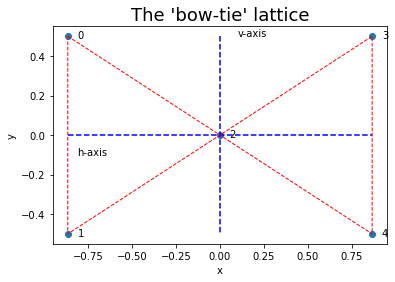

In [4]:
# Make the grid
x=[-0.866,-0.866,0,0.866,0.866]
y=[0.5,-0.5,0,0.5,-0.5]
z=[0,0,0,0,0]

plt.scatter(x,y)
for i,val in enumerate(x):
    plt.annotate(i,(x[i],y[i]), xytext=(x[i]+0.055,y[i]-0.01))
plt.annotate("h-axis",(-0.866,0),xytext=(-0.866+0.055,0-0.1))
plt.annotate("v-axis",(0,0.5),xytext=(0+0.1,0.5))

plt.plot(x,y,"r--",linewidth="1")
plt.plot([-0.866,0.866],[0,0],"b--")
plt.plot([0,0],[0.5,-0.5],"b--")
plt.plot([-0.866,0,0.866],[0.5,0,-0.5],"r--",linewidth="1")
    
plt.title("The 'bow-tie' lattice",fontsize=18)
plt.xlabel("x")
plt.ylabel("y")

**Definition of $H$** Here we define the reference value for the ground state energy. We diagonalize the Heisenberg Hamiltonian.

In [5]:
nqubit  = 5
nn_list = [(0,1),(1,2),(0,2),(2,3),(2,4),(3,4)]
H       = generate_Heisenberg(nqubit,nn_list)

ee = NumPyMinimumEigensolver(H)
result = ee.run()
ref = result.eigenvalue.real
print('Ground state energy: {}'.format(ref))

2021-04-28 16:10:59,130:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-6.+4.23113481e-17j]),
    'eigvecs': array([[-3.89776402e-17+5.10165548e-17j,  3.61974282e-17-1.42030259e-17j,
         8.72303518e-17+4.15500394e-17j, -2.74499843e-16-1.28677068e-17j,
         1.74630000e-16-3.55387935e-16j, -2.69765989e-01+1.54170485e-01j,
         2.69765989e-01-1.54170485e-01j,  4.28729112e-17-2.16661053e-16j,
         2.85313390e-17-1.15117520e-17j, -2.04190753e-03+1.70368077e-01j,
        -2.09060026e-01-5.23325184e-02j, -2.43608213e-01-1.37865820e-01j,
         2.11101934e-01-1.18035559e-01j,  2.84548430e-01+1.86481592e-01j,
        -4.09402170e-02-4.86157720e-02j,  5.60415841e-17+5.98826011e-17j,
         1.27195165e-17-1.81207333e-17j,  2.71807897e-01-3.24538562e-01j,
        -6.07059631e-02+2.06503003e-01j,  2.43608213e-01+1.37865820e-01j,
        -2.11101934e-01+1.18035559e-01j, -1.54045849e-01-2.04018620e-01j,
        -

Ground state energy: -6.000000000000012


We create the Hamiltonian matrix.

In [6]:
mat_H = H.to_matrix()
print(mat_H)

[[6.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 2.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 2.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 2.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 2.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 6.+0.j]]


**Definition of $S_x,S_y,S_z,S^2$**

In [7]:
sx=[]
for i in range (nqubit):
    sx.append((1.0/2.,generate_pauli([i],[],nqubit)))
sx=WeightedPauliOperator(sx)
print("Sx operator")
print(sx.print_details())
mat_sx=op_converter.to_matrix_operator(sx).dense_matrix
#print("Sx operator matrix")
#print(mat_sx)

sy=[]
for i in range (nqubit):
    sy.append((1.0/2.,generate_pauli([i],[i],nqubit)))
sy=WeightedPauliOperator(sy)
print("Sy operator")
print(sy.print_details())
mat_sy=op_converter.to_matrix_operator(sy).dense_matrix
#print("Sy operator matrix")
#print(mat_sy)

sz=[]
for i in range (nqubit):
    sz.append((1.0/2.,generate_pauli([],[i],nqubit)))
sz=WeightedPauliOperator(sz)
print("Sz operator")
print(sz.print_details())
mat_sz=op_converter.to_matrix_operator(sz).dense_matrix
#print("Sz operator matrix")
#print(mat_sz)

s2=np.dot(sx,sx)+np.dot(sy,sy)+np.dot(sz,sz)
print("S2 operator")
print(s2.print_details())
mat_s2=op_converter.to_matrix_operator(s2).dense_matrix
#print("S2 operator matrix")
#print(mat_s2)

Sx operator
IIIIX	(0.5+0j)
IIIXI	(0.5+0j)
IIXII	(0.5+0j)
IXIII	(0.5+0j)
XIIII	(0.5+0j)

Sy operator
IIIIY	(0.5+0j)
IIIYI	(0.5+0j)
IIYII	(0.5+0j)
IYIII	(0.5+0j)
YIIII	(0.5+0j)

Sz operator
IIIIZ	(0.5+0j)
IIIZI	(0.5+0j)
IIZII	(0.5+0j)
IZIII	(0.5+0j)
ZIIII	(0.5+0j)

S2 operator
IIIII	(3.75+0j)
IIIXX	(0.5+0j)
IIXIX	(0.5+0j)
IXIIX	(0.5+0j)
XIIIX	(0.5+0j)
IIXXI	(0.5+0j)
IXIXI	(0.5+0j)
XIIXI	(0.5+0j)
IXXII	(0.5+0j)
XIXII	(0.5+0j)
XXIII	(0.5+0j)
IIIYY	(0.5+0j)
IIYIY	(0.5+0j)
IYIIY	(0.5+0j)
YIIIY	(0.5+0j)
IIYYI	(0.5+0j)
IYIYI	(0.5+0j)
YIIYI	(0.5+0j)
IYYII	(0.5+0j)
YIYII	(0.5+0j)
YYIII	(0.5+0j)
IIIZZ	(0.5+0j)
IIZIZ	(0.5+0j)
IZIIZ	(0.5+0j)
ZIIIZ	(0.5+0j)
IIZZI	(0.5+0j)
IZIZI	(0.5+0j)
ZIIZI	(0.5+0j)
IZZII	(0.5+0j)
ZIZII	(0.5+0j)
ZZIII	(0.5+0j)



# Clebsh-Gordan coefficients

If we call the sum of the spins in sites $0-1$ as $\textbf{left-spin}$, $\hat{S}_l$, the sum of the spins in sites $3-4$ as $\textbf{right-spin}$, $\hat{S}_r$, and the spin in site $2$ as $\textbf{middle-spin}$, $\hat{S}_m$, we can have $4$ configurations related to $\hat{S}_l$, $\hat{S}_m$ and $\hat{S}_r$ eigenvalues, $(s_l,s_m,s_r)$. They are shown below.

$$ A=(1, \frac{1}{2} ,1) \quad B=(1, \frac{1}{2} ,0) \quad C=(0, \frac{1}{2} ,1) \quad D=(0, \frac{1}{2} ,0)$$

We can create a table in which we can classify the eigenstates of the Hamiltonian. 

| Energy | Degeneracy | Spin $S$ | Configuration |
| :-: | :-: | :-: | :-: |
| 6 | 6 | $\frac{5}{2}$ | $(1, \frac{1}{2} ,1)$ |
| 4 | 4 | $\frac{3}{2}$ | $(1, \frac{1}{2} ,1)$ |
| 2 | 2 | $\frac{1}{2}$ | $(1, \frac{1}{2} ,1)$ |
| 0 | 8 | $\frac{3}{2}$ | $(1, \frac{1}{2} ,0)$ - $(0, \frac{1}{2} ,1)$ |
|-2 | 2 | $\frac{1}{2}$ | $(1, \frac{1}{2} ,1)$ |
|-4 | 4 | $\frac{3}{2}$ | $(1, \frac{1}{2} ,1)$ |
|-6 | 6 | $\frac{1}{2}$ | $(1, \frac{1}{2} ,0)$ - $(0, \frac{1}{2} ,0)$  - $(0, \frac{1}{2} ,1)$ |

Now we show the lowest energy eigenstates, namely the eigenstates associated with $E_{GS}=-6$. We will refer to the single-qubit state $i$ of the lattice with $s_z=\frac{1}{2}$ and $s_z=-\frac{1}{2}$ as $\uparrow_i$ and $\downarrow_i$, respectively. 

$$
\begin{align}
& |B,s=\frac{1}{2},s_z=\frac{1}{2} \rangle=\sqrt{\frac{1}{3}} \biggl[\uparrow_0 \uparrow_1 \downarrow_2 -  \frac{1}{2} \biggl( \uparrow_0 \downarrow_1 + \downarrow_0 \uparrow_1 \biggr) \uparrow_2 \biggr] \biggl(\uparrow_3\downarrow_4 -\downarrow_3 \uparrow_4 \biggr) \quad \text{+ (spin flip, sign change)}\\
& |C,s=\frac{1}{2},s_z=\frac{1}{2} \rangle= \sqrt{\frac{1}{3}} \biggl(\uparrow_0 \downarrow_1 -\downarrow_0 \uparrow_1 \biggr) \biggl[\downarrow_2 \uparrow_3 \uparrow_4-  \frac{1}{2} \uparrow_2 \biggl( \uparrow_3 \downarrow_4 + \downarrow_3 \uparrow_4 \biggr)  \biggr] \quad \text{+ (spin flip, sign change)}  \\
& |D,s=\frac{1}{2},s_z=\frac{1}{2} \rangle = \frac{1}{2} \biggl(\uparrow_0 \downarrow_1 -\downarrow_0 \uparrow_1 \biggr) \uparrow_2 \biggl(\uparrow_3 \downarrow_4 -\downarrow_3 \uparrow_4 \biggr) \quad \text{+ spin flip (same with}\downarrow_2\text{)}
\end{align}
$$

Those expressions are obtained using the Clebsh-Gordan coefficients. 

In [8]:
def sign(x):
    if(x>0): 
        return  1
    else:    
        return -1

def convert(x):
    return int(round(np.abs(2*x)))

def get_clebsch(j1,m1,j2,m2,J,M):
    from sympy.physics.quantum.cg import CG
    # S is the shortcut for sympify and converts an arbitrary expression to a type that can be used inside SymPy
    sgnJ  = sign(J) 
    from sympy import S     
    sgnM  = sign(M)
    sgnj1 = sign(j1)
    sgnm1 = sign(m1)
    sgnj2 = sign(j2)
    sgnm2 = sign(m2)
    numJ  = convert(J)
    numM  = convert(M)
    numj1 = convert(j1)
    numm1 = convert(m1)
    numj2 = convert(j2)
    numm2 = convert(m2)
    cg = CG(sgnj1*S(numj1)/2,sgnm1*S(numm1)/2,sgnj2*S(numj2)/2,sgnm2*S(numm2)/2,sgnJ*S(numJ)/2,sgnM*S(numM)/2)
    return float(cg.doit().evalf())

# ------------------------------------------------------

# Remark - It's important to notice that the vector associated with psi_JM is a matrix, therefore the indexes we print in the following function are the
#          matrix indexes on which we have a non-zero value. By this way the indexes can be read also as up or down spin vectors.
#          E.g. (0,1,1) --> (up,down,down)

def print_states(psi_dict):
    for k in psi_dict.keys():
        print("State ",k)
        n = len(psi_dict[k].shape)
        for idx in itertools.product([0,1],repeat=n):
            c = psi_dict[k][idx]
            # If we don't insert the following "if", we would see all the null contributes to the state |J,M>
            if(not isclose(c,0.0,abs_tol=1e-4)):
                print(idx," ",c)
        print(" ")
            
# Given the z-component of spin, m, the following function returns the vectors (1 0)^T (j=1/2, m=1/2) or (0 1)^T (j=1/2, m=-1/2)
def one_spin_states(j,m):
    # isclose returns True if two values are closer than the abs_tol
    if(isclose(m,0.5,abs_tol=1e-4)):        
        i=0
    else:                            
        i=1
    psi    = np.zeros(2)
    psi[i] = 1.0
    return psi[:]

def compose_two_spins(label=''):
    psi = {}
    j1,j2 = 1.0/2.0,1.0/2.0
    for J in [0,1]:
        for M in range(-J,J+1):
            psi_JM = np.zeros((2,2))
            for x1 in [0,1]:
                for x2 in [0,1]:
                    m1,m2 = (x1-j1),(x2-j2)
                    cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                    psi_JM += cg*np.einsum('a,b->ab',one_spin_states(j1,m1),one_spin_states(j2,m2))
            #print(psi_JM)
            psi[label+'_'+str(J)+'_'+str(M)] = psi_JM
    return psi

def compose_with_center(psi_left,label=''):
    psi = {}
    j2 = 1.0/2.0
    for j1 in [0,1]:
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            for M in np.arange(-J,J+1e-4,1.0):
                psi_JM_j1 = np.zeros((2,2,2))
                for x1 in range(2*j1+1):
                    for x2 in [0,1]:
                        m1,m2 = (x1-j1),(x2-j2)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi_JM_j1 += cg*np.einsum('ab,c->abc',psi_left[label+'_'+str(j1)+'_'+str(m1)],one_spin_states(j2,m2))
                psi[label+'_j1_'+str(j1)+'_lc_'+str(J)+'_'+str(M)] = psi_JM_j1
    return psi

def compose_with_right(psi_lc,psi_r):
    psi={}
    lc_list=[]

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))

    for k in psi_r.keys():
        kr=k.split("_")
        lab_r=kr[0]
        break

    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for j2 in [0,1]:
            for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
                #print(" ",J)
                for M in np.arange(-J,J+1e-4,1.0):
                    # Label with spin left jL, spin right jR and spin left + center jLC 
                    lab = 'jL_'+str(jL)+'_jR_'+str(j2)+'_jLC_'+str(j1)+'_LCR_'+str(J)+'_'+str(M)
                    psi[lab] = np.zeros((2,2,2,2,2))
                    for m1 in np.arange(-j1,j1+1e-4,1):
                        for m2 in np.arange(-j2,j2+1e-4,1):
                            lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                            lab2=lab_r+'_'+str(j2)+'_'+str(int(m2))
                            cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                            psi[lab] += cg*np.einsum('abc,de->abcde',psi_lc[lab1],psi_r[lab2])
    return psi

def compose_with_right1(psi_lc):
    psi={}
    lc_list=[]
    j2=1./2.

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))
    
    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            #print(" ",J)
            for M in np.arange(-J,J+1e-4,1.0):
                # Label with spin left jL, spin left+center jLC and spin LCR1
                lab = 'jL_'+str(jL)+'_jLC_'+str(j1)+'_LCR1_'+str(J)+'_'+str(M)
                psi[lab] = np.zeros((2,2,2,2))
                for m1 in np.arange(-j1,j1+1e-4,1):
                    for m2 in np.arange(-j2,j2+1e-4,1):
                        lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi[lab] += cg*np.einsum('abc,d->abcd',psi_lc[lab1],one_spin_states(j2,m2))
                        
    return psi

def compose_with_right2(psi_lcr1):
    psi={}
    lc_list=[]
    j2=1./2.

    for k in psi_lcr1.keys():
        k_lcr1 = k.split('_')
        jL  = float(k_lcr1[1])
        jLC = float(k_lcr1[3])
        j1  = float(k_lcr1[5])
        if((jL,jLC,j1) not in lc_list):
            lc_list.append((jL,jLC,j1))
    
    for el in lc_list:
        jL  = int(el[0])
        jLC = el[1]
        j1  = el[2]
        #print(jL," ",jLC," ",j1)
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            #print(" ",J)
            for M in np.arange(-J,J+1e-4,1.0):
                # Label with spin left jL, spin left+center jLC, spin LCR1 and LCR1R2 
                lab = 'jL_'+str(jL)+'_jLC_'+str(jLC)+'_LCR1_'+str(j1)+'_LCR1R2_'+str(J)+'_'+str(M)
                psi[lab] = np.zeros((2,2,2,2,2))
                for m1 in np.arange(-j1,j1+1e-4,1):
                    for m2 in np.arange(-j2,j2+1e-4,1):
                        lab1='jL_'+str(jL)+'_jLC_'+str(jLC)+'_LCR1_'+str(j1)+'_'+str(m1)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi[lab] += cg*np.einsum('abcd,e->abcde',psi_lcr1[lab1],one_spin_states(j2,m2))
                        
    return psi


We show the states coming from the composition of the left spin states (sites $0$ and $1$): they are the states of singlet and triplet. 

The notation uses $L$ to refer to the spin position and the two following numbers to refer to the spin value $s$ and the $z$-component $s_z$. The indexes inside round brackets can be read as spin $\uparrow$ and $\downarrow$ of the spins in sites $0$ and $1$.



$$(0,0) \rightarrow (\uparrow, \uparrow)  \quad (0,1) \rightarrow (\uparrow, \downarrow) \quad (1,0) \rightarrow (\downarrow, \uparrow) \quad (1,1) \rightarrow (\downarrow,\downarrow)$$

Therefore we expect the following left states:

$$\begin{align}
& |s=0,s_z=0 \rangle = \frac{1}{\sqrt{2}} \biggl(| \uparrow_0 \downarrow_1 \rangle - | \downarrow_0 \uparrow_1 \rangle\biggr)\\
& |s=1,s_z = -1 \rangle = | \downarrow_0 \downarrow_1 \rangle  \\
& |s=1,s_z=0 \rangle = \frac{1}{\sqrt{2}} \biggl(| \uparrow_0 \downarrow_1 \rangle + | \downarrow_0 \uparrow_1 \rangle\biggr)\\
& |s=1,s_z = 1 \rangle = | \uparrow_0 \uparrow_1 \rangle 
\end{align}$$

In [9]:
psi_L      = compose_two_spins('L')
psi_R      = compose_two_spins('R')
psi_LC     = compose_with_center(psi_L,'L')
psi_LCR    = compose_with_right(psi_LC,psi_R)
psi_LCR1   = compose_with_right1(psi_LC)
psi_LCR1R2 = compose_with_right2(psi_LCR1)

print("States L - Number: ",len(psi_L.keys()))
print_states(psi_L)

States L - Number:  4
State  L_0_0
(0, 1)   0.7071067811865476
(1, 0)   -0.7071067811865476
 
State  L_1_-1
(1, 1)   1.0
 
State  L_1_0
(0, 1)   0.7071067811865476
(1, 0)   0.7071067811865476
 
State  L_1_1
(0, 0)   1.0
 


#### Total spin eigenstates built with composition "one-to-one"

In [10]:
psi2=[]
for v in psi_LCR1R2.values():
    psi2.append(np.concatenate(np.concatenate(np.concatenate(np.concatenate(v)))))

Then we have to combine the previous $4$ states with the middle spin with spin $s=1/2$ and we get the following states. 

Here the label $j1$ appearing in the notation refers to the left spin value and the two numbers after the label $lc$ refer to the spin $s$ and $z$-component $s_z$ of the spins in sites $0$,$1$ and $2$.

In [11]:
print("States LC - Number: ",len(psi_LC.keys()))
print_states(psi_LC)

eig_3spins=[]
for v in psi_LC.values():
    # We use concatenate 2 times because the vectors have been built using np.zeros((2,2,2))
    eig_3spins.append(np.concatenate(np.concatenate(v)))

States LC - Number:  8
State  L_j1_0_lc_0.5_-0.5
(0, 1, 1)   0.7071067811865476
(1, 0, 1)   -0.7071067811865476
 
State  L_j1_0_lc_0.5_0.5
(0, 1, 0)   0.7071067811865476
(1, 0, 0)   -0.7071067811865476
 
State  L_j1_1_lc_0.5_-0.5
(0, 1, 1)   0.408248290463863
(1, 0, 1)   0.408248290463863
(1, 1, 0)   -0.816496580927726
 
State  L_j1_1_lc_0.5_0.5
(0, 0, 1)   0.816496580927726
(0, 1, 0)   -0.408248290463863
(1, 0, 0)   -0.408248290463863
 
State  L_j1_1_lc_1.5_-1.5
(1, 1, 1)   1.0
 
State  L_j1_1_lc_1.5_-0.5
(0, 1, 1)   0.5773502691896258
(1, 0, 1)   0.5773502691896258
(1, 1, 0)   0.5773502691896257
 
State  L_j1_1_lc_1.5_0.5
(0, 0, 1)   0.5773502691896257
(0, 1, 0)   0.5773502691896258
(1, 0, 0)   0.5773502691896258
 
State  L_j1_1_lc_1.5_1.5
(0, 0, 0)   1.0
 


At the end we combine the $8$ states coming from the sites $\{0,1,2\}$ with the spin of the states $\{3,4\}$. We will find the expected $32$ states of the problem.

Each state is labelled with the left and right spin values and with the spin value of the sites $\{0,1,2\}$ because there are two ways to get spin $s=1/2$ with the combination of left spin with middle spin, one with the left spin $s=0$ and the other with $s=1$.

In [12]:
print("States LCR - Number: ",len(psi_LCR.keys()))
print_states(psi_LCR)

States LCR - Number:  32
State  jL_0_jR_0_jLC_0.5_LCR_0.5_-0.5
(0, 1, 1, 0, 1)   0.5000000000000001
(0, 1, 1, 1, 0)   -0.5000000000000001
(1, 0, 1, 0, 1)   -0.5000000000000001
(1, 0, 1, 1, 0)   0.5000000000000001
 
State  jL_0_jR_0_jLC_0.5_LCR_0.5_0.5
(0, 1, 0, 0, 1)   0.5000000000000001
(0, 1, 0, 1, 0)   -0.5000000000000001
(1, 0, 0, 0, 1)   -0.5000000000000001
(1, 0, 0, 1, 0)   0.5000000000000001
 
State  jL_0_jR_1_jLC_0.5_LCR_0.5_-0.5
(0, 1, 0, 1, 1)   0.5773502691896258
(0, 1, 1, 0, 1)   -0.2886751345948129
(0, 1, 1, 1, 0)   -0.2886751345948129
(1, 0, 0, 1, 1)   -0.5773502691896258
(1, 0, 1, 0, 1)   0.2886751345948129
(1, 0, 1, 1, 0)   0.2886751345948129
 
State  jL_0_jR_1_jLC_0.5_LCR_0.5_0.5
(0, 1, 0, 0, 1)   0.2886751345948129
(0, 1, 0, 1, 0)   0.2886751345948129
(0, 1, 1, 0, 0)   -0.5773502691896258
(1, 0, 0, 0, 1)   -0.2886751345948129
(1, 0, 0, 1, 0)   -0.2886751345948129
(1, 0, 1, 0, 0)   0.5773502691896258
 
State  jL_0_jR_1_jLC_0.5_LCR_1.5_-1.5
(0, 1, 1, 1, 1)   0.707106781

**Expectation value on $H$, $S^2$ and $S_z$** The next step is to verify if some of those states are eigenstates of our Hamiltonian. For completeness we also calculate the expectation value of spin $S^2$ and $S_z$. If we call the states $|\psi_i \rangle$, we study:

$$E_i = \langle \psi_i | H | \psi_i \rangle \quad s(s+1) = \langle \psi_i | S^2 | \psi_i \rangle \quad s_z = \langle \psi_i | S_z | \psi_i \rangle$$

with $i=0,...,31$.

In [13]:
mat_H2=np.dot(mat_H,mat_H)

psi=[]
for v in psi_LCR.values():
    # We use concatenate 4 times because the vectors have been built using np.zeros((2,2,2,2,2))
    psi.append(np.concatenate(np.concatenate(np.concatenate(np.concatenate(v)))))

gs=[]
for i,key in enumerate(psi_LCR.keys()):
    lab=key.split('_')
    print(i, ") JL=",lab[1]," JR=",lab[3]," JLC=",lab[5]," J=",lab[7]," M=",lab[8])
    if np.round(np.dot(np.conjugate(np.transpose(psi[i])),psi[i]),3)==1:
        E=np.real(np.dot(np.conjugate(np.transpose(psi[i])),np.dot(mat_H,psi[i])))
        E2=np.real(np.dot(np.conjugate(np.transpose(psi[i])),np.dot(mat_H2,psi[i])))
        if np.round(E,3)==-6.:
            # We save the position of the vector among the 32 and the vector itself
            gs.append((i,psi[i]))
        print("<H> = ",np.round(E,3))
        print("<H^2> - <H>^2 = ",E2-E**2)
        print("<S2> = ",np.round(np.real(np.dot(np.conjugate(np.transpose(psi[i])),np.dot(mat_s2,psi[i]))),3))
        print("<Sz> = ",np.round(np.real(np.dot(np.conjugate(np.transpose(psi[i])),np.dot(mat_sz,psi[i]))),3),"\n")

0 ) JL= 0  JR= 0  JLC= 0.5  J= 0.5  M= -0.5
<H> =  -6.0
<H^2> - <H>^2 =  -2.842170943040401e-14
<S2> =  0.75
<Sz> =  -0.5 

1 ) JL= 0  JR= 0  JLC= 0.5  J= 0.5  M= 0.5
<H> =  -6.0
<H^2> - <H>^2 =  -2.842170943040401e-14
<S2> =  0.75
<Sz> =  0.5 

2 ) JL= 0  JR= 1  JLC= 0.5  J= 0.5  M= -0.5
<H> =  -6.0
<H^2> - <H>^2 =  0.0
<S2> =  0.75
<Sz> =  -0.5 

3 ) JL= 0  JR= 1  JLC= 0.5  J= 0.5  M= 0.5
<H> =  -6.0
<H^2> - <H>^2 =  0.0
<S2> =  0.75
<Sz> =  0.5 

4 ) JL= 0  JR= 1  JLC= 0.5  J= 1.5  M= -1.5
<H> =  0.0
<H^2> - <H>^2 =  0.0
<S2> =  3.75
<Sz> =  -1.5 

5 ) JL= 0  JR= 1  JLC= 0.5  J= 1.5  M= -0.5
<H> =  -0.0
<H^2> - <H>^2 =  1.0877919644084154e-15
<S2> =  3.75
<Sz> =  -0.5 

6 ) JL= 0  JR= 1  JLC= 0.5  J= 1.5  M= 0.5
<H> =  -0.0
<H^2> - <H>^2 =  -3.6259732146947126e-16
<S2> =  3.75
<Sz> =  0.5 

7 ) JL= 0  JR= 1  JLC= 0.5  J= 1.5  M= 1.5
<H> =  0.0
<H^2> - <H>^2 =  0.0
<S2> =  3.75
<Sz> =  1.5 

8 ) JL= 1  JR= 0  JLC= 0.5  J= 0.5  M= -0.5
<H> =  -6.0
<H^2> - <H>^2 =  -1.4210854715202004e

We note that the states with spin $s=1/2$ and configuration $(1,1/2,0)$, $(0,1/2,1)$ and $(0,1/2,0)$ are exact ground states of our Hamiltonian. The same observation can be made with the states which have energy equal to $0$ and $6$. 

Besides, the eigenstates of $H$ with energy equal to $-2,-4,2,4$ are not directly given among the $32$ above.

**Example** We now study one of the two excited states with energy $E=-4$ given by Barbara. The first state is the following:

$$ 
\begin{align}
& E=-4 \quad s=\frac{3}{2}, \, s_z=\frac{3}{2} \quad \text{Configuration:} \biggl( 1,1/2,1 \biggr) \\ 
& \frac{1}{2\sqrt{5}} \biggl[ \biggl( \uparrow_0 \downarrow_1 + \downarrow_0 \uparrow_1 \biggr) \uparrow_2 \uparrow_3 \uparrow_4 + \uparrow_0 \uparrow_1 \uparrow_2 \biggl( \uparrow_3 \downarrow_4 + \downarrow_3 \uparrow_4 \biggr) - 4 \uparrow_0 \uparrow_1 \downarrow_2 \uparrow_3 \uparrow_4 \biggr]
\end{align}
$$

In [13]:
psi_exc={}
lab="sz_"+str(1.5)
psi_exc[lab]=np.zeros((2,2,2,2,2))
psi_exc[lab][(0,1,0,0,0)]=1/(2*np.sqrt(5))
psi_exc[lab][(1,0,0,0,0)]=1/(2*np.sqrt(5))
psi_exc[lab][(0,0,0,0,1)]=1/(2*np.sqrt(5))
psi_exc[lab][(0,0,0,1,0)]=1/(2*np.sqrt(5))
psi_exc[lab][(0,0,1,0,0)]=-4/(2*np.sqrt(5))

v=np.concatenate(np.concatenate(np.concatenate(np.concatenate(psi_exc[lab]))))

print("Expected energy: ", np.dot(np.conjugate(np.transpose(v)),np.dot(mat_H,v)))

Expected energy:  (-4+0j)


We recognize inside the previous state the vectors which compose $|J_L=1, J_R=0, J_{LC}=3/2, J=3/2,M=3/2 \rangle$ and $|J_L=1, J_R=1, J_{LC}=1/2, J=3/2,M=1/2 \rangle$:

$$
\begin{align}
& |J_L=1, J_R=0, J_{LC}=3/2, J=3/2,M=3/2 \rangle = \frac{1}{\sqrt{2}} \biggl( |\uparrow_0 \uparrow_1 \uparrow_2 \uparrow_3 \downarrow_4 \rangle - |\uparrow_0 \uparrow_1 \uparrow_2 \downarrow_3 \uparrow_4 \rangle \biggr) \\
& |J_L=1, J_R=1, J_{LC}=1/2, J=3/2,M=1/2 \rangle = \sqrt{\frac{2}{3}} | \uparrow_0 \uparrow_1 \downarrow_2 \uparrow_3 \uparrow_4 \rangle - \sqrt{\frac{1}{6}} \biggl( |\uparrow_0 \downarrow_1 \uparrow_2 \uparrow_3 \uparrow_4 \rangle + | \downarrow_0 \uparrow_1 \uparrow_2 \uparrow_3 \uparrow_4 \rangle \biggr)
\end{align} 
$$

# How to build the unitary matrix $U$ which sends the state $|0\rangle^{\otimes 5}$ to the ground state?

## 1) From Clebsh-Gordan states

We know want the unitary matrix $U$ which acts as follows:

$$U_i |0 \rangle^{\otimes 5} = |GS_i\rangle$$

where $i$ is used to distinguish from different lowest energy states $|GS_i \rangle$. 

**Example** We consider the case of a vector $(a \, b \, c \, d)^T$ living in a $4$-dimensional space. We can build the unitary matrix $U$ by considering that this matrix works on zero-state, $(1 \, 0 \, 0 \, 0)^T$. The same thing will be with $|0 \rangle^{\otimes 5}$. U acts as follows:

$$\begin{pmatrix}
a & * & * & * \\
b & * & * & * \\
c & * & * & * \\
d & * & * & * 
\end{pmatrix}
\begin{pmatrix}
1 \\
0 \\
0 \\
0 \\
\end{pmatrix}=
\begin{pmatrix}
a  \\
b  \\
c \\
d 
\end{pmatrix}$$

The space with $*$ can be filled keeping the transformation unitary. 

In our problem we will consider the orthonormal basis given by the "Clebsh-Gordan vectors" as columns of the unitary matrix $U$ and we will put in the first column the state we want to get. In fact the columns and rows of a unitary matrix form an orthonormal basis.

#### Check - Are the "Clebsh-Gordan vectors" orthonormal?

In [27]:
truth=True
for i,vi in enumerate(psi):
    for j,vj in enumerate(psi):
        if i!=j:
            if np.round(np.dot(np.conjugate(vi),vj),10)!=0:
                truth=False
        else:
            if np.round(np.dot(np.conjugate(psi[i]),psi[i]),10)!=1.:
                truth=False
if truth:
    print("They are orthonormal!")

They are orthonormal!


**Definition of $U$ for the lowest energy states**

We define $U_i$ for each of the ground states.

In [28]:
# Definition of |00000>
v0=np.zeros(2**nqubit,dtype=np.complex_)
v0[0]=1

U=[]
for idx,s in gs:
    u=np.zeros((2**nqubit,2**nqubit),dtype=np.complex_)
    for i in range(len(psi)):
        if i==0:
            u[:,i]=s
        elif i==idx:
            u[:,i]=psi[0]
        else:
            u[:,i]=psi[i]
    U.append(u)
    
#eig,_=LA.eigh(U)
#print("Matrix U rank: ",np.linalg.matrix_rank(U))
    
Id=np.identity(2**nqubit,dtype=np.complex_)
count=0
for u in U:
    if np.all(np.round(np.dot(np.transpose(np.conjugate(u)),u),5)==Id):
        count+=1
if(count==6):
    print("All matrices in U are unitary!")

All matrices in U are unitary!


Now we can build the circuits which creates the matrices $U_i$.

In [30]:
U_qc=[]
for i,u in enumerate(U):
    qc=QuantumCircuit(QuantumRegister(nqubit,'q'))
    u_op=Operator(u)
    lab="U_"+str(i)
    qc.unitary(u_op,[0,1,2,3,4],label=lab)
    #print(qc.draw())
    U_qc.append(qc)

**Example** We transpile the circuit corresponding to $U_0$, but we notice that the circuit is complicated and odd.

In [32]:
# nn_list_v has the following shape: [[0,1],[0,2],...,[3,4]]
nn_list_v=[]
for el in nn_list:
    nn_v=[]
    nn_v.append(el[0])
    nn_v.append(el[1])
    nn_list_v.append(nn_v)
    
trans_qc=transpile(U_qc[0],basis_gates=['u','cx'],coupling_map=nn_list_v)
trans_qc.draw()

global phase: 115.325563602273
         ┌───────────────────────────┐┌─────────┐     ┌─────────┐»
q_0 -> 0 ┤ U(0,0,-0.819503545695944) ├┤ U2(0,π) ├──■──┤ U2(0,π) ├»
         └────────┬─────────┬────────┘└─────────┘┌─┴─┐├─────────┤»
q_1 -> 1 ─────────┤ U2(0,π) ├────────────────────┤ X ├┤ U2(0,π) ├»
                  ├─────────┤                    └───┘└─────────┘»
q_2 -> 2 ─────────┤ U2(0,π) ├────────────────────────────────────»
                  └─────────┘         ┌─────────┐     ┌─────────┐»
q_3 -> 3 ──────────────■──────────────┤ U2(0,π) ├──■──┤ U2(0,π) ├»
                     ┌─┴─┐            ├─────────┤┌─┴─┐├─────────┤»
q_4 -> 4 ────────────┤ X ├────────────┤ U2(0,π) ├┤ X ├┤ U2(0,π) ├»
                     └───┘            └─────────┘└───┘└─────────┘»
«         ┌──────────────────────────┐┌─────────┐     ┌─────────┐»
«q_0 -> 0 ┤ U(0,0,0.448993624060725) ├┤ U2(0,π) ├──■──┤ U2(0,π) ├»
«         └───────┬─────────┬────────┘└─────────┘  │  └─────────┘»
«q_1 -> 1 ────────┤ U2(0,π) ├──────────────────────┼─────────────»
«                 └─────────┘                    ┌─┴─┐┌─────────┐»
«q_2 -> 2 ───────────────────────────────────────┤ X ├┤ U2(0,π) ├»
«                                     ┌─────────┐└───┘└─────────┘»
«q_3 -> 3 ─────────────■──────────────┤ U2(0,π) ├────────────────»
«                    ┌─┴─┐            ├─────────┤                »
«q_4 -> 4 ───────────┤ X ├────────────┤ U2(0,π) ├────────────────»
«                    └───┘            └─────────┘                »
«         ┌──────────────────────────┐┌─────────┐     ┌─────────┐»
«q_0 -> 0 ┤ U(0,0,0.317277378560877) ├┤ U2(0,π) ├──■──┤ U2(0,π) ├»
«         └──────────────────────────┘└─────────┘┌─┴─┐├─────────┤»
«q_1 -> 1 ───────────────────────────────────────┤ X ├┤ U2(0,π) ├»
«                                                └───┘└─────────┘»
«q_2 -> 2 ───────────────────────────────────────────────────────»
«                                                                »
«q_3 -> 3 ───────────────────────────────────────────────────────»
«                                                                »
«q_4 -> 4 ───────────────────────────────────────────────────────»
«                                                                »
«         ┌──────────────────────────┐     ┌─────────┐     ┌─────────┐     »
«q_0 -> 0 ┤ U(0,0,0.224564720383547) ├──■──┤ U2(0,π) ├──■──┤ U2(0,π) ├──■──»
«         └──────────────────────────┘  │  └─────────┘  │  └─────────┘  │  »
«q_1 -> 1 ──────────────────────────────┼───────────────┼───────────────┼──»
«                                     ┌─┴─┐┌─────────┐┌─┴─┐┌─────────┐┌─┴─┐»
«q_2 -> 2 ────────────────────────────┤ X ├┤ U2(0,π) ├┤ X ├┤ U2(0,π) ├┤ X ├»
«                                     └───┘└─────────┘└───┘└─────────┘└───┘»
«q_3 -> 3 ─────────────────────────────────────────────────────────────────»
«                                                                          »
«q_4 -> 4 ─────────────────────────────────────────────────────────────────»
«                                                                          »
«                                                                     »
«q_0 -> 0 ────────────────────────────────────────────────────────────»
«                                                                     »
«q_1 -> 1 ─────────────────────────────────────────────────────────■──»
«         ┌─────────┐     ┌─────────┐┌──────────────────────────┐┌─┴─┐»
«q_2 -> 2 ┤ U2(0,π) ├──■──┤ U2(0,π) ├┤ U(0,0,0.118508297004403) ├┤ X ├»
«         └─────────┘  │  └─────────┘└──────────────────────────┘└───┘»
«q_3 -> 3 ─────────────┼──────────────────────────────────────────────»
«                    ┌─┴─┐┌─────────┐        ┌─────────┐              »
«q_4 -> 4 ───────────┤ X ├┤ U2(0,π) ├────────┤ U2(0,π) ├──────────────»
«                    └───┘└─────────┘        └─────────┘              »
«                                                                             »
«q_0 -> 0 ─────────────────────────────

## 2) With Shur Transform

The following idea comes from the following paper: _Kirby, Strauch - A PRACTICAL QUANTUM ALGORITHM FOR THE SCHUR TRANSFORM_.

The Schur transform is an operation on a quantum computer that maps the standard computational basis to a basis composed of irreducible representations of the unitary and symmetric groups, the **Schur basis**. For qubits, the Schur basis is composed of eigenvectors of the total spin of the whole register. 

By adding a logarithmic (in $n$= number of qubits) number of **ancillary qubits**, we can label the states in the Schur basis: the multiplicities of the spin-subspace ($|A\rangle$), the inequivalent irreducible representations ($|B\rangle$) and finally the states within the irreducible representations ($|c\rangle$).
So we have to deal with:

$$|A\rangle \otimes |B\rangle \otimes |C\rangle$$

In [33]:
"""
William M. Kirby, wmkirby1@gmail.com, 2018
Computes an efficient quantum algorithm for the Schur transform on n qubits.
Based on theory developed by Frederick W. Strauch and William M. Kirby.

Main procedures:

schuralg(n) returns a list of operators whose product is the Schur transform on n qubits.
The list has length O(n^3).
List elements have the form [t,op,b], where op is a one- or two-level rotation operator, t is a number of qubits to be tensored in above the operator, and b is a number of qubits to be tensored in below the operator.
That is, the Schur transform is given by the product of the operations identity(2**t) tensor op tensor identity(2**b) for each element [t,op,b] in schuralg(n).

schurmat(n) returns the Schur transform on n qubits in the matrix form as it will be implemented by the sequence of operations schuralg(n).

schurmatrestrict(n) returns the Schur transform on n qubits in matrix form, showing only the computational rows and columns: this will be a 2**n by 2**n matrix.

schurindices(n) returns a dict s mapping keys of the form 'j,l,m' to indices corresponding to output entries of the quantum operation implemented by schuralg(n).
Here j refers to the total spin of some spin-subspace, l is a multiplicity identifier for that spin-subspace, and m is a particular spin-projection.
Thus 'j,l,m' refers to a specific basis state in the output of the Schur transform as implemented by schuralg(n), and s['j,l,m'] returns the row encoding that basis state.

"""

import math
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

# Returns the lowering operator on a composite system composed of two subsystems: one with dimension d, and the other with dimension 2.
def lop(d):
    j=(d-1)/2 # Get effective total spin for d-dimensional subsystem.
    lop1=[] # Lowering operator for d-dimensional subsystem.
    lop1.append([0 for i in range(d)]) # 0th row of lowering operator is zero.
    for i in range(d-1):
        e=[0 for i in range(d)]
        e[i]=np.sqrt(j*(j+1)-(j-i)*(j-i-1)) # Build (i+1)th row in lowering operator.
        lop1.append(e)
    return np.kron(lop1,np.identity(2))+np.kron(np.identity(d),[[0,0],[1,0]]) # Add lowering operator on first subsystem to lowering operator on second subsystem.

# Returns the Clebsch-Gordan transform that combines a d-dimensional subsystem with a qubit.
# Input entries (columns) correspond to |m_1,m_2>, where m_1 and m_2 are the subsystem spin-projections.
# Output entries (rows) correspond to |j_t,m_t>, where j_t is the composite total spin and m_t is the composite spin-projection.
def cg(d):
    if d==1:
        return np.identity(2) # If the first subsystem has dimension 1, the CG transform is the identity of dimension 1*2==2.
    else:
        j=(d-1)/2 # Get effective total spin for d-dimensional subsystem.
        out=[] # Will contain output matrix.
        vec=[0 for i in range(2*d)] # Initialize current row vector for first state in spin-(d+1/2) output subsystem.
        vec[0]=1
        out.append(vec)
        lopd=lop(d) # Lowering operator for composite of d-dimensional subsystem and qubit.
        for i in range(d): # Compute the remainder of the rows corresponding to composite total spin d+1/2.
            vec=np.dot(lopd,vec)/np.linalg.norm(np.dot(lopd,vec)) # Compute new row (apply lowering operator to previous row and normalize).
            out.append(vec)
        vec=[0 for i in range(2*d)] # Initialize current row vector for first state in spin-(d-1/2) output subsystem.
        # Must be a linear combination of input states |d,-1/2> and |d-1,1/2> that is orthogonal to the linear combination of these states in the spin-(d+1/2) subspace.
        vec[1]=out[1][2]
        vec[2]=-out[1][1]
        out.append(vec)
        for i in range(d-2): # Compute the remainder of the rows corresponding to composite total spin d-1/2.
            vec=np.dot(lopd,vec)/np.linalg.norm(np.dot(lopd,vec)) # Compute new row (apply lowering operator to previous row and normalize).
            out.append(vec)
        return out

# The Schur transform is obtained recursively.
# Assume that we have obtained the Schur transform on n qubits, that is, we have a unitary map from the individual spin eigenstates |m_1,...,m_n> to the composite spin eigenstates |j,m,l>, where l is an index for the multiplicity of the spin-j subspace.

# Let D=n+1, the highest dimension of any spin-subspace.
# Then assume that in the output of the existing map, each spin-subspace (particular value of j and l) occupies the first 2j+1 states in some block of 2^(ceil(log_2(D))) entries:
# that is, assume that our output vector is divided into blocks, called J-blocks, whose size is the least power of two such that any spin-subspace can be contained in one J-block.

# Let K=ceil(D/2): this is the number of distinct values of j in the output of the existing map.
# Assume the J-blocks are organized into sets of 2^(ceil(log_2(K))), called L-blocks:
# the first K J-blocks in each L-block correspond to the K distinct spin-j subspaces, organized by decreasing j.

# Lastly, let L be the largest value of l for any j: assume that there are 2^(ceil(log_2(L))) L-blocks.

# The iteration performs the same operation on each L-block.

# Our iteration must add a qubit, map to the new spin-subspaces, and reorganize so that the output matches the description above for the new values of D, K, and L.

# We break up the iteration step into two piece: cgblocks, which maps to the new spin-subspaces, and cgrearrange, which reorganizes the output as described above.
# cgblocks and cgrearrange will describe only the operation on a single L-block: this operation will be copied over the L-blocks later.

# Adds a new qubit to n qubits that have already been mapped to composite spin eigenvectors.
def cgblocks(n):
    # Set parameters:
    d_in=[n+1-2*i for i in range(math.ceil((n+1)/2))] # Dimensions of spin-subspaces for n qubits, in decreasing order.
    d_out=[n+2-2*i for i in range(math.ceil((n+2)/2))] # Dimensions of spin-subspaces for n+1 qubits, in decreasing order.
    jblock_in=2**(math.ceil(np.log2(d_in[0]))) # Number of entries in input J-block.
    jblock_out=2**(math.ceil(np.log2(d_out[0]))) # Number of entries in output J-block.
    k_in=len(d_in) # Number of input spin-subspaces.
    k_out=len(d_out) # Number of output spin-subspaces.
    lblock_in=jblock_in*(2**(math.ceil(np.log2(k_in)))) # Number of entries in input L-block.
    lblock_out=jblock_out*(2**(math.ceil(np.log2(k_out)))) # Number of entries in output L-block.
    if not n==1:
        dim=2*lblock_out # Typically, at least one output spin-subspace will have two copies, so need two output L-blocks...
    else:
        dim=lblock_out # Except in the case n==1.
    # Build operation:
    mat=np.identity(dim) # Initialize output matrix.
    for i in range(k_in): # Iterate over input spin-subspaces.
        current_cg=cg(d_in[i]) # Get CG transform for current spin-subspace.
        for j in range(2*d_in[i]): # Iterate over entries in current CG transform.
            for k in range(2*d_in[i]):
                mat[2*i*jblock_in+j][2*i*jblock_in+k]=current_cg[j][k] # Insert current CG transform.
    return mat

# Permutes the rows so that the output matches the assumptions described above.
def cgrearrange(n):
    # Set parameters:
    d_in=[n+1-2*i for i in range(math.ceil((n+1)/2))] # Dimensions of spin-subspaces for n qubits, in decreasing order.
    d_out=[n+2-2*i for i in range(math.ceil((n+2)/2))] # Dimensions of spin-subspaces for n+1 qubits, in decreasing order.
    jblock_in=2**(math.ceil(np.log2(d_in[0]))) # Number of entries in input J-block.
    jblock_out=2**(math.ceil(np.log2(d_out[0]))) # Number of entries in output J-block.
    k_in=len(d_in) # Number of input spin-subspaces.
    k_out=len(d_out) # Number of output spin-subspaces.
    lblock_in=jblock_in*(2**(math.ceil(np.log2(k_in)))) # Number of entries in input L-block.
    lblock_out=jblock_out*(2**(math.ceil(np.log2(k_out)))) # Number of entries in output L-block.
    if not n==1:
        dim=2*lblock_out # Typically, at least one output spin-subspace will have two copies, so need two output L-blocks...
    else:
        dim=lblock_out # In the case n==1.
    # Build operation:
    pert=[] # Will contain the permutations to be implemented by the operation.
    for i in range(k_in): # Iterate over input spin-subspaces.
        for j in range(d_in[i]+1): # Iterate over rows corresponding to larger output spin-subspace.
            pert.append([2*i*jblock_in+j,i*jblock_out+j])# Put larger output spin-subspace in first output L-block.
        if d_in[i]>1: # If there is a second, smaller output spin-subspace...
            for j in range(d_in[i]-1): # Iterate over rows corresponding to smaller output spin-subspace.
                if not n==1:
                    pert.append([2*i*jblock_in+d_in[i]+1+j,lblock_out+(i+1)*jblock_out+j]) # Put smaller output spin-subspace in second output L-block, unless n==1.
                else:
                    pert.append([2*i*jblock_in+d_in[i]+1+j,(i+1)*jblock_out+j]) # If n==1, put smaller output spin-subspace also in first output L-block.
    # Generate active parts of the permutation matrix that implements the two-cycles represented by pert.
    mat=[[0 for i in range(dim)] for i in range(dim)] # Initialize output matrix.
    for i in pert: # Insert permutations into mat.
        mat[i[1]][i[0]]=1
    # Fill in the remainder of the permutation matrix.
    starts=[i[0] for i in pert]
    ends=[i[1] for i in pert]
    for i in range(dim): # Insert main diagonal 1s where possible.
        if (not i in starts) and (not i in ends):
            mat[i][i]=1
            ends.append(i)
    unused=[i for i in range(dim) if i not in ends]
    for i in range(dim): # Map remaining input entries to free output entries.
        if (not 1 in np.array(mat)[:,i]):
            mat[unused.pop()][i]=1
    return mat

# Special row swap operator: swaps rows 1 and 4 in an 8x8 matrix.
# Will be used to reconcile output of one iteration with input of the next when the L-block and J-block size changes.
spec_swap=np.array([[1,0,0,0,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])

# Returns a list of quantum operations to performed in order to implement the quantum Schur transform on n qubits.
# Output is a list whose elements have the form [t,op,b]:
# op is a generalized CG transform,
# t is a number of qubits to be tensored in above op,
# b is a number of qubits to be tensored in below op.
# That is, the element [t,op,b] corresponds to the quantum operation
# identity(2**t) tensor op tensor identity(2**b).
# Assumes n is an integer greater than 1, since the Schur transform on 1 qubit is the identity matrix.
def schurops(n):
    if n==2:
        return [[0,np.dot(cgrearrange(1),cgblocks(1)),0]] # The Schur transform on 2 qubits is the CG transform.
    else:
        prev=schurops(n-1) # Get Schur transform on n-1 qubits.
        for elem in prev:
            elem[2]=elem[2]+1 # Add one new qubit below each operation in previous Schur transform.
        if math.ceil(np.log2(n))==np.log2(n): # If n is a power of 2...
            for elem in prev:
                elem[0]=elem[0]+2 # Add two new qubits above each operation in previous Schur transform.
            prev.insert(0,[0,spec_swap,n-6+np.log2(len(cgrearrange(n-1)))])#spec_swap
            prev.insert(0,[n-3,np.dot(cgrearrange(n-1),cgblocks(n-1)),0])
        else:
            prev.insert(0,[n-3,np.dot(cgrearrange(n-1),cgblocks(n-1)),0])
        return prev

# Returns the decomposition of real unitary matrix u into a product of two-level "Givens" rotations and one-level phase operations.
# Output is a list of matrices, all one- or two-level rotations, whose product is u.
def givens(u):
    d=len(u) # Dimension of target matrix.
    v=u # Working matrix.
    out=[] # Will contain output list.
    # Get two-level rotations to reduce v to diagonal:
    for i in range(1,d): # Iterate over lower triangle in v.
        for j in range(i):
            if not v[i,j]==0: # If current entry in v is not already zero...
                # Build two-level rotation [[b,-c],[c,b]] to zero current entry in v:
                nm=np.sqrt(abs(v[i,j])**2+abs(v[j,j])**2)
                b=v[j,j]/nm
                c=-v[i,j]/nm
                g=np.identity(d)
                g[j,j]=b
                g[i,j]=c
                g[j,i]=-c
                g[i,i]=b
                # Add conjugate transpose of g to output:
                out.append(np.matrix(g).getH())
                # Update v:
                v=np.dot(g,v)
    # Get one-level phase rotations to reduce v to identity:
    for i in range(d):
        if not v[i][i]==1:
            g=np.identity(d)
            g[i][i]=v[i][i]
            out.append(np.matrix(g).getH())
            v=np.dot(g,v)
    return out

# MAIN PROCEDURE
# Returns a list of quantum operations to performed in order to implement the quantum Schur transform on n qubits.
# Output is a list whose elements have the form [t,op,b]:
# op is a one- or two-level rotation,
# t is a number of qubits to be tensored in above op,
# b is a number of qubits to be tensored in below op.
# That is, the element [t,op,b] corresponds to the quantum operation
# identity(2**t) tensor op tensor identity(2**b).
# Assumes n is an integer greater than 1, since the Schur transform on 1 qubit is the identity matrix.
def schuralg(n):
    inlist=schurops(n)
    outlist=[]
    while inlist:
        next=inlist.pop()
        ngivens=givens(next[1])
        while ngivens:
            outlist.insert(0,[next[0],ngivens.pop(),next[2]])
    return outlist

# Returns the Schur transform matrix in the form that will be implemented by the quantum algorithm returned by schuralg(n).
def schurmat(n):
    ops=schurops(n)
    mat=ops.pop()
    mat=np.kron(np.kron(np.identity(2**mat[0]),mat[1]),np.identity(2**mat[2]))
    while ops:
        next=ops.pop()
        next=np.kron(np.kron(np.identity(int(2**next[0])),next[1]),np.identity(int(2**next[2])))
        mat=np.dot(next,mat)
    return mat

# Returns the computational part of the Schur transform matrix: i.e. the first 2^n columns and the rows they map to.
def schurmatrestrict(n):
    mat=schurmat(n)
    mat=[mat[i][0:2**n] for i in range(len(mat))]
    i=0
    while i<len(mat):
        if not np.any(mat[i]):
            del mat[i]
        else:
            i=i+1
    return mat

# Returns a dict s mapping keys of the form 'j,l,m' to indices corresponding to output entries in the quantum operation implemented by schuralg(n).
# Here j refers to the total spin of some spin-subspace, l is a multiplicity identifier for that spin-subspace, and m is a particular spin-projection.
# Thus 'j,l,m' refers to a specific basis state in the output of the Schur transform as implemented by schuralg(n), and s['j,l,m'] returns the row encoding that basis state.
# Assumes l is an integer and j, m are half-integers to one decimal place precision.
def schurindices(n):
    out={}
    mat=schurmat(n)
    mat=[mat[i][0:2**n] for i in range(len(mat))]
    activerows=[] # Stores indices of active rows.
    mults=[0 for i in range(math.floor(n/2)+1)] # Stores current values of multiplicity identifiers.
    for i in range(len(mat)):
        if np.any(mat[i]):
            activerows.append(i)
    i=0
    d=1
    while i<len(activerows):
        while (i+d<len(activerows)) and (d<=n) and (activerows[i+d]-1==activerows[i+d-1]):
            d=d+1
        j=(d-1)/2 # Total spin of current spin-subspace.
        multindex=int((n-d+1)/2)
        for k in range(d):
            out['{:.1f},{:d},{:.1f}'.format(j,mults[multindex],j-k)]=activerows[i+k]
        i=i+d
        mults[multindex]=mults[multindex]+1
        d=1
    return out

Now we use the algorithm.

In [34]:
schur_op=schuralg(nqubit)
print("Number of elements: ",len(schur_op))

Number of elements:  72


In [35]:
print(schurindices(nqubit))

{'2.5,0,2.5': 0, '2.5,0,1.5': 1, '2.5,0,0.5': 2, '2.5,0,-0.5': 3, '2.5,0,-1.5': 4, '2.5,0,-2.5': 5, '1.5,0,1.5': 8, '1.5,0,0.5': 9, '1.5,0,-0.5': 10, '1.5,0,-1.5': 11, '1.5,1,1.5': 40, '1.5,1,0.5': 41, '1.5,1,-0.5': 42, '1.5,1,-1.5': 43, '0.5,0,0.5': 48, '0.5,0,-0.5': 49, '1.5,2,1.5': 72, '1.5,2,0.5': 73, '1.5,2,-0.5': 74, '1.5,2,-1.5': 75, '0.5,1,0.5': 80, '0.5,1,-0.5': 81, '0.5,2,0.5': 112, '0.5,2,-0.5': 113, '1.5,3,1.5': 136, '1.5,3,0.5': 137, '1.5,3,-0.5': 138, '1.5,3,-1.5': 139, '0.5,3,0.5': 176, '0.5,3,-0.5': 177, '0.5,4,0.5': 208, '0.5,4,-0.5': 209}


In [36]:
print(len(schur_op[0][1]))

64


In [37]:
qc=QuantumCircuit(QuantumRegister(6,'q'))
u_op=Operator(schur_op[0][1])
qc.unitary(u_op,[0,1,2,3,4,5],label="U")
print(qc.draw())

     ┌────┐
q_0: ┤0   ├
     │    │
q_1: ┤1   ├
     │    │
q_2: ┤2   ├
     │  U │
q_3: ┤3   ├
     │    │
q_4: ┤4   ├
     │    │
q_5: ┤5   ├
     └────┘


In [38]:
trans_qc=transpile(qc,basis_gates=['ry','rz','cx'])
trans_qc.draw()

global phase: 0
     ┌──────────────┐┌───┐┌────────────┐┌───┐┌───────────────┐┌───┐»
q_0: ┤ RZ(-0.92512) ├┤ X ├┤ RZ(0.3653) ├┤ X ├┤ RZ(-0.027397) ├┤ X ├»
     └──────────────┘└─┬─┘└────────────┘└─┬─┘└───────────────┘└─┬─┘»
q_1: ──────────────────■──────────────────┼─────────────────────■──»
                                          │                        »
q_2: ─────────────────────────────────────■────────────────────────»
                                                                   »
q_3: ──────────────────────────────────────────────────────────────»
                                                                   »
q_4: ──────────────────────────────────────────────────────────────»
                                                                   »
q_5: ──────────────────────────────────────────────────────────────»
                                                                   »
«     ┌─────────────┐┌───┐┌────────────┐┌───┐┌─────────────┐┌───┐┌────────────┐»
«q_0: ┤ RZ(0.48419) ├┤ X ├┤ RZ(1.1203) ├┤ X ├┤ RZ(-0.6635) ├┤ X ├┤ RZ(1.2392) ├»
«     └─────────────┘└─┬─┘└────────────┘└─┬─┘└─────────────┘└─┬─┘└────────────┘»
«q_1: ─────────────────┼──────────────────■───────────────────┼────────────────»
«                      │                                      │                »
«q_2: ─────────────────┼──────────────────────────────────────■────────────────»
«                      │                                                       »
«q_3: ─────────────────■───────────────────────────────────────────────────────»
«                                                                              »
«q_4: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«q_5: ─────────────────────────────────────────────────────────────────────────»
«                                                                              »
«     ┌───┐┌─────────────┐┌───┐┌───────────────┐┌───┐┌─────────────┐┌───┐»
«q_0: ┤ X ├┤ RZ(0.78842) ├┤ X ├┤ RZ(0.0030194) ├┤ X ├┤ RZ(0.45377) ├┤ X ├»
«     └─┬─┘└─────────────┘└─┬─┘└───────────────┘└─┬─┘└─────────────┘└─┬─┘»
«q_1: ──■───────────────────┼─────────────────────■───────────────────┼──»
«                           │                                         │  »
«q_2: ──────────────────────┼─────────────────────────────────────────■──»
«                           │                                            »
«q_3: ──────────────────────┼────────────────────────────────────────────»
«                           │                                            »
«q_4: ──────────────────────■────────────────────────────────────────────»
«                                                                        »
«q_5: ───────────────────────────────────────────────────────────────────»
«                                                                        »
«     ┌────────────┐┌───┐┌─────────────┐┌───┐┌─────────────┐┌───┐»
«q_0: ┤ RZ(0.1219) ├┤ X ├┤ RZ(0.33489) ├┤ X ├┤ RZ(-1.0866) ├┤ X ├»
«     └────────────┘└─┬─┘└─────────────┘└─┬─┘└─────────────┘└─┬─┘»
«q_1: ────────────────■───────────────────┼───────────────────■──»
«                                         │                      »
«q_2: ────────────────────────────────────┼──────────────────────»
«                                         │                      »
«q_3: ────────────────────────────────────■──────────────────────»
«                                                                »
«q_4: ───────────────────────────────────────────────────────────»
«                                                                »
«q_5: ───────────────────────────────────────────────────────────»
«                                                                »
«     ┌───────────────┐┌───┐┌────────────┐┌───┐┌──────────────┐┌───┐»
«q_0: ┤ RZ(-0.027397) ├┤ X ├┤ RZ(0.3653) ├┤ X ├┤ RZ(0.091486) ├┤ X ├»
«     └───────────────┘└─┬─┘└────────────┘└─┬─┘└

**Problem** The transpilation of the unitary matrices of the previous circuit gives a complicated circuit.

## 3) Mario's method

### 3a - Composing spins one by one

Given two spins, e.g. the left spins, we can build the circuit which creates the singlet and triplet states.

<img src="Pictures/CG1.jpg" width="300">

In the picture we create a state with spin $j=l$ and $z$-component $m=M-1/2$.

$$\begin{align}
& \text{Singlet} \quad \frac{|\uparrow_0 \downarrow_1 \rangle -|\downarrow_0 \uparrow_1 \rangle}{\sqrt{2}} \quad  G=XH \quad G'=X \\
& \text{Triplet} \quad
\begin{cases}
&|\uparrow_0 \uparrow_1 \rangle \quad & G=\mathbb{1} \quad G'=\mathbb{1} \\
&\frac{1}{\sqrt{2}}\Bigl(|\uparrow_0 \downarrow_1 \rangle +|\downarrow_0 \uparrow_1 \rangle \Bigr)  \quad & G=H \quad G'=X\\
&|\downarrow_0 \downarrow_1 \rangle \quad & G=X \quad G'=\mathbb{1}
\end{cases}
\end{align}
$$

I started from the idea of Mario of composing the left spins (sites $\{0,1\}$) using the **CNOT** gate and the **RY** rotation. In other words I composed the left spins following the rule:

$$|J,M,j_1=l,j_2=\frac{1}{2} \rangle = \text{cos}(\theta) |j_1=l, m_1=M-1/2 \rangle |j_2=1/2, m_2=1/2 \rangle + \text{sin}(\theta) |j_1=l, m_1=M+1/2 \rangle |j_2=1/2, m_2=-1/2 \rangle$$

where $l \in \{J-1/2,J+1/2\}$. The corresponding circuit is below.

<img src="Pictures/CG2.jpg" width="500">

We can continue this process by adding the remaining two spins one by one. This is a recursive procedure.

<img src="Pictures/CG3.jpg" width="600">

For simplicity I used the names $V$, $V'$,$W$ and $W'$ for the gates. Those circuits work in the same way of the circuit inside $V$. 

We remark that the states we get are not the "Clebsh-Gordan states" above, but they can be used to build those states with linear combinations.

In [14]:
def to_ket(psi):
    """ Write a statevector in braket notation.
    Parameters
    ----------
    ψ: ndarray
        the statevector
    Returns
    -------
    ket: str
        the statevector in braket notation
    """
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    # CONSTRUCT STRING ONE STATE AT A TIME
    ket = ""
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING
        # UPDATE ket STRING
        if np.round(c,3)!=0.:
            if i > 0: ket += " + "
            ket += f"({c:.3f}) |{label}⟩"   # (OPTIONAL) FIX COEFFICIENT'S PRECISION
    return ket

def to_state(psi):
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    #state = np.zeros(len(psi),dtype=np.complex_)
    state=np.zeros(len(psi),dtype=float)
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING

        v=[np.zeros(2,dtype=float) for i in range(n)]
        for k in range(n):
            v[k][int(label[k])]=1.
                    
        #print(label,v)
        val=np.kron(v[0],v[1])
        for j in range(2,n):
            val=np.kron(val,v[j])
        val=np.dot(c,val)
        state+=val
    return state

def two_spin(J,M):                      # Two spin 1/2
    qr = QuantumRegister(2,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        qc.x(0)
        qc.h(0)
        qc.x(1)
    else:
        if M==0:
            qc.h(0)
            qc.x(1)
        elif M==-1:
            qc.x(0)
    qc.cx(0,1)
    #print(qc.draw())
    #two_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    two_spin=qc.to_gate(label="2-spin")
    return two_spin

def two_to_three(l,M):
    qr = QuantumRegister(2,'q')                 
    qc = QuantumCircuit(qr)
    qc.append(two_spin(l,M-0.5).inverse(),[0,1])
    qc.append(two_spin(l,M+0.5),[0,1])
    ttt=qc.to_gate(label="L+C")
    return ttt

def three_spin(l,J,M):                                 # Three spin 1/2
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    theta=np.arccos(get_clebsch(l,M-0.5,0.5,0.5,J,M))  # Gives the angle to use in the Ry Gate
    #print("theta_LC = ",theta)
    
    qc.append(two_spin(l,M-0.5),[0,1])
    qc.ry(2*theta,2)                                   # Remember that we need to insert 2*theta
    qc.append(two_to_three(l,M).control(1),[2,0,1])    # Target [0,1], Control [2]
    #print(qc.draw())
    three_spin=qc.to_gate(label="LC-spin")
    return three_spin

qr = QuantumRegister(3,'q')                 
qc = QuantumCircuit(qr)
qc.append(three_spin(0,0.5,0.5),[0,1,2])
qc.draw()

┌──────────┐
q_0: ┤0         ├
     │          │
q_1: ┤1 LC-spin ├
     │          │
q_2: ┤2         ├
     └──────────┘

#### Check - Composition of $2$ spins

In [40]:
print("M |00> = ", to_ket(np.real(np.dot(Operator(two_spin(0,0)).data,[1,0,0,0]))))
print("M |00> = ",to_state(np.real(np.dot(Operator(two_spin(0,0)).data,[1,0,0,0]))))

M |00> =   + (-0.707) |10⟩ + (0.707) |01⟩
M |00> =  [ 0.          0.70710678 -0.70710678  0.        ]


#### Check - Composition of $3$ spins

In [41]:
mat_gate=Operator(three_spin(1,1.5,-0.5)).data
#print(mat_gate)
v0=np.zeros(2**3)
v0[0]=1
print("M |000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))))
print("M |000> = ", to_state(np.real(np.round(np.dot(mat_gate,v0),3))))

M |000> =   + (0.577) |110⟩ + (0.577) |101⟩ + (0.577) |011⟩
M |000> =  [0.    0.    0.    0.577 0.    0.577 0.577 0.   ]


The composition of the left spin with the middle spin works as we wanted!

Now we study the composition with the right spin. We try to do that by composing the left+middle spin with the two $\frac{1}{2}$-spins.

In [15]:
def three_to_four(l,lc,M):
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    qc.append(three_spin(l,lc,M-0.5).inverse(),[0,1,2])
    qc.append(three_spin(l,lc,M+0.5),[0,1,2])
    ttf=qc.to_gate(label="LC+R1")
    return ttf

def four_spin(l,lc,J,M):                                    # Four spin 1/2
    qr = QuantumRegister(4,'q')                 
    qc = QuantumCircuit(qr)
    
    theta=np.arccos(get_clebsch(lc,M-0.5,0.5,0.5,J,M))       # Gives the angle to use in the Ry Gate
    #print("theta_LCR1 = ",theta)
    
    qc.append(three_spin(l,lc,M-0.5),[0,1,2])
    qc.ry(2*theta,3)                                         # Remember that we need to insert 2*theta
    qc.append(three_to_four(l,lc,M).control(1),[3,0,1,2])    # Target [0,1,2], Control [3]
    #print(qc.draw())
    four_spin=qc.to_gate(label="LCR1-spin")
    return four_spin

qr = QuantumRegister(4,'q')                 
qc = QuantumCircuit(qr)
qc.append(four_spin(0,0.5,1.,1.),[0,1,2,3])

#### Check - Composition of $4$ spins

In [43]:
v0=np.zeros(2**4)
v0[0]=1

i=1
l,lc,J=0.,0.5,0.
print(i,") l=",l," lc=",lc," J=",J," M=",0)
mat_gate=Operator(four_spin(l,lc,J,0)).data
print("M |0000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))),"\n")
i+=1

l,lc,J=0.,0.5,1.
for M in np.arange(-1,1+1e-4,1.):
    print(i,") l=",l," lc=",lc," J=",J," M=",M)
    mat_gate=Operator(four_spin(l,lc,J,M)).data
    print("M |0000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))),"\n")
    i+=1
    
l,lc,J=1.,0.5,0.
print(i,") l=",l," lc=",lc," J=",J," M=",0)
mat_gate=Operator(four_spin(l,lc,J,0)).data
print("M |0000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))),"\n")
i+=1

l,lc,J=1.,0.5,1.
for M in np.arange(-1,1+1e-4,1.):
    print(i,") l=",l," lc=",lc," J=",J," M=",M)
    mat_gate=Operator(four_spin(l,lc,J,M)).data
    print("M |0000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))),"\n")
    i+=1

l,lc,J=1.,1.5,1.
for M in np.arange(-1,1+1e-4,1.):
    print(i,") l=",l," lc=",lc," J=",J," M=",M)
    mat_gate=Operator(four_spin(l,lc,J,M)).data
    print("M |0000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))),"\n")
    i+=1
    
l,lc,J=1.,1.5,2.
for M in np.arange(-2,2+1e-4,1.):
    print(i,") l=",l," lc=",lc," J=",J," M=",M)
    mat_gate=Operator(four_spin(l,lc,J,M)).data
    print("M |0000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))),"\n")
    i+=1

1 ) l= 0.0  lc= 0.5  J= 0.0  M= 0
M |0000> =   + (0.500) |1010⟩ + (-0.500) |0110⟩ + (-0.500) |1001⟩ + (0.500) |0101⟩ 

2 ) l= 0.0  lc= 0.5  J= 1.0  M= -1.0
M |0000> =   + (-0.707) |1011⟩ + (0.707) |0111⟩ 

3 ) l= 0.0  lc= 0.5  J= 1.0  M= 0.0
M |0000> =   + (-0.500) |1010⟩ + (0.500) |0110⟩ + (-0.500) |1001⟩ + (0.500) |0101⟩ 

4 ) l= 0.0  lc= 0.5  J= 1.0  M= 1.0
M |0000> =   + (-0.707) |1000⟩ + (0.707) |0100⟩ 

5 ) l= 1.0  lc= 0.5  J= 0.0  M= 0
M |0000> =   + (0.577) |1100⟩ + (-0.289) |1010⟩ + (-0.289) |0110⟩ + (-0.289) |1001⟩ + (-0.289) |0101⟩ + (0.577) |0011⟩ 

6 ) l= 1.0  lc= 0.5  J= 1.0  M= -1.0
M |0000> =   + (-0.816) |1101⟩ + (0.408) |1011⟩ + (0.408) |0111⟩ 

7 ) l= 1.0  lc= 0.5  J= 1.0  M= 0.0
M |0000> =   + (-0.577) |1100⟩ + (0.289) |1010⟩ + (0.289) |0110⟩ + (-0.289) |1001⟩ + (-0.289) |0101⟩ + (0.577) |0011⟩ 

8 ) l= 1.0  lc= 0.5  J= 1.0  M= 1.0
M |0000> =   + (-0.408) |1000⟩ + (-0.408) |0100⟩ + (0.816) |0010⟩ 

9 ) l= 1.0  lc= 1.5  J= 1.0  M= -1.0
M |0000> =   + (-0.866) |1110⟩ 

We now go from the $4$-th to the $5$-th spin by composing their spin vectors. By this way the states are **classified with the left spin, the left-middle spin and left-middle-right spin**, instead of labelling the states with the left, right and left-middle spins.

In [26]:
def four_to_five(l,lc,lcr1,M):
    qr = QuantumRegister(4,'q')                 
    qc = QuantumCircuit(qr)
    qc.append(four_spin(l,lc,lcr1,M-0.5).inverse(),[0,1,2,3])
    qc.append(four_spin(l,lc,lcr1,M+0.5),[0,1,2,3])
    ftf=qc.to_gate(label="LCR1+R2")
    return ftf

def five_spin(l,lc,lcr1,J,M):                                      # Five spin 1/2
    qr = QuantumRegister(nqubit,'q')                 
    qc = QuantumCircuit(qr)
    
    theta=np.arccos(get_clebsch(lcr1,M-0.5,0.5,0.5,J,M))           # Gives the angle to use in the Ry Gate
    #print("theta_LCR1R2 = ",theta)
    
    qc.append(four_spin(l,lc,lcr1,M-0.5),[0,1,2,3])
    qc.ry(2*theta,4)                                               # Remember that we need to insert 2*theta
    qc.append(four_to_five(l,lc,lcr1,M).control(1),[4,0,1,2,3])    # Target [0,1,2,3], Control [4]
    #print(qc.draw())
    five_spin=qc.to_gate(label="LCR1R2-spin")
    return five_spin
    
qr = QuantumRegister(nqubit,'q')                 
qc = QuantumCircuit(qr)
qc.append(five_spin(0,0.5,0.,0.5,0.5),[0,1,2,3,4])
#print(qc.depth())

#### Check - Composition of $5$ spins

In [17]:
v0=np.zeros(2**nqubit)
v0[0]=1

i=1

l,lc,lcr1,J=0.,0.5,0.,0.5
for M in np.arange(-J,J+1e-4,1.):
    print(i,") l=",l," lc=",lc," lcr1=",lcr1," J=",J," M=",M)
    mat_gate=Operator(five_spin(l,lc,lcr1,J,M)).data
    print("M |00000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))))
    s=to_state(np.real(np.dot(mat_gate,v0)))

    # Fidelity
    print("|< ideal | circuit >|^2 = ",np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
    print("Precision: 1- |< ideal | circuit >|^2 = ", 1-np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
    
    # Energy
    E=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H,s)))
    E2=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H2,s)))
    print("<H> = ",np.round(E,3))
    print("<H^2> - <H>^2 = ",E2-E**2,"\n")
    
    i+=1
    
l,lc,lcr1=0.,0.5,1.
for J in [0.5,1.5]:
    for M in np.arange(-J,J+1e-4,1.):
        print(i,") l=",l," lc=",lc," lcr1=",lcr1," J=",J," M=",M)
        mat_gate=Operator(five_spin(l,lc,lcr1,J,M)).data
        print("M |00000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))))
        s=to_state(np.real(np.dot(mat_gate,v0)))
    
        # Fidelity
        print("|< ideal | circuit >|^2 = ",np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
        print("Precision: 1- |< ideal | circuit >|^2 = ", 1-np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
    
        # Energy
        E=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H,s)))
        E2=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H2,s)))
        print("<H> = ",np.round(E,3))
        print("<H^2> - <H>^2 = ",E2-E**2,"\n")
        
        i+=1

1 ) l= 0.0  lc= 0.5  lcr1= 0.0  J= 0.5  M= -0.5
M |00000> =   + (0.500) |10101⟩ + (-0.500) |01101⟩ + (-0.500) |10011⟩ + (0.500) |01011⟩
|< ideal | circuit >|^2 =  0.9999999999999574
Precision: 1- |< ideal | circuit >|^2 =  4.263256414560601e-14
<H> =  -6.0
<H^2> - <H>^2 =  1.5631940186722204e-12 

2 ) l= 0.0  lc= 0.5  lcr1= 0.0  J= 0.5  M= 0.5
M |00000> =   + (0.500) |10100⟩ + (-0.500) |01100⟩ + (-0.500) |10010⟩ + (0.500) |01010⟩
|< ideal | circuit >|^2 =  0.9999999999999956
Precision: 1- |< ideal | circuit >|^2 =  4.440892098500626e-15
<H> =  -6.0
<H^2> - <H>^2 =  1.7053025658242404e-13 

3 ) l= 0.0  lc= 0.5  lcr1= 1.0  J= 0.5  M= -0.5
M |00000> =   + (0.577) |10110⟩ + (-0.577) |01110⟩ + (-0.289) |10101⟩ + (0.289) |01101⟩ + (-0.289) |10011⟩ + (0.289) |01011⟩
|< ideal | circuit >|^2 =  0.9999999999999838
Precision: 1- |< ideal | circuit >|^2 =  1.6209256159527285e-14
<H> =  -6.0
<H^2> - <H>^2 =  5.897504706808832e-13 

4 ) l= 0.0  lc= 0.5  lcr1= 1.0  J= 0.5  M= 0.5
M |00000> =   + (0.2

| Label $(s_{01},s_{012},s_{0123},s,s_z)$| $\langle \hat{H} \rangle$ | $\langle \hat{H}^2 \rangle - \langle \hat{H} \rangle^2$  | $1-|\langle \psi_{ideal}|\psi_{circuit} \rangle|^2$ |
| :-: | :-: | :-: | :-: |
|<img width=150/>|<img width=100/>|<img width=100/>|<img width=150/>|
|$(0,1/2,0,1/2,-1/2)$|$-6.0$|$1.56 \cdot 10^{-12}$|$4.26 \cdot 10^{-14}$|
| $(0,1/2,0,1/2,1/2)$  | $-6.0$ | $1.71 \cdot 10^{-13}$ | $4.44 \cdot 10^{-15}$|
| $(0,1/2,1,1/2,-1/2)$ | $-6.0 $| $5.90 \cdot 10^{-13}$ | $1.62 \cdot 10^{-14}$|
| $(0,1/2,1,1/2,1/2)$ | $-6.0$ | $6.25 \cdot 10^{-13}$ | $1.73 \cdot 10^{-14}$|
|$(0,1/2,1,3/2,-3/2)$ | $0.0$ | $1.41 \cdot 10^{-28}$ | $5.64 \cdot 10^{-14}$|
|$(0,1/2,1,3/2,-1/2)$ | $0.0$ | $3.63 \cdot 10^{-16}$ | $2.78 \cdot 10^{-14}$|
|$(0,1/2,1,3/2,1/2)$ | $0.0$ | $3.63 \cdot 10^{-16}$ |$1.60 \cdot 10^{-14}$|
|$(0,1/2,1,3/2,3/2)$ | $0.0$ | 7.40 $\cdot 10^{-32}$ |$2.44 \cdot 10^{-15}$|

In [18]:
l,lc,lcr1,J=1.,0.5,0.,0.5
for M in np.arange(-J,J+1e-4,1.):
    print(i,") l=",l," lc=",lc," lcr1=",lcr1," J=",J," M=",M)
    mat_gate=Operator(five_spin(l,lc,lcr1,J,M)).data
    print("M |00000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))))
    s=to_state(np.real(np.dot(mat_gate,v0)))
    
    # Fidelity
    print("|< ideal | circuit >|^2 = ",np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
    print("Precision: 1- |< ideal | circuit >|^2 = ", 1-np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
    
    E=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H,s)))
    E2=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H2,s)))
    print("<H> = ",np.round(E,3))
    print("<H^2> - <H>^2 = ",E2-E**2,"\n")
    i+=1
    
l,lc,lcr1=1.,0.5,1.
for J in [0.5,1.5]:
    for M in np.arange(-J,J+1e-4,1.):
        print(i,") l=",l," lc=",lc," lcr1=",lcr1," J=",J," M=",M)
        mat_gate=Operator(five_spin(l,lc,lcr1,J,M)).data
        print("M |00000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))))
        s=to_state(np.real(np.dot(mat_gate,v0)))
        
        # Fidelity
        print("|< ideal | circuit >|^2 = ",np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
        print("Precision: 1- |< ideal | circuit >|^2 = ", 1-np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
        
        E=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H,s)))
        E2=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H2,s)))
        print("<H> = ",np.round(E,3))
        print("<H^2> - <H>^2 = ",E2-E**2,"\n")
        
        i+=1

9 ) l= 1.0  lc= 0.5  lcr1= 0.0  J= 0.5  M= -0.5
M |00000> =   + (0.577) |11001⟩ + (-0.289) |10101⟩ + (-0.289) |01101⟩ + (-0.289) |10011⟩ + (-0.289) |01011⟩ + (0.577) |00111⟩
|< ideal | circuit >|^2 =  0.9999999999999658
Precision: 1- |< ideal | circuit >|^2 =  3.419486915845482e-14
<H> =  -2.0
<H^2> - <H>^2 =  7.999999999999864 

10 ) l= 1.0  lc= 0.5  lcr1= 0.0  J= 0.5  M= 0.5
M |00000> =   + (0.577) |11000⟩ + (-0.289) |10100⟩ + (-0.289) |01100⟩ + (-0.289) |10010⟩ + (-0.289) |01010⟩ + (0.577) |00110⟩
|< ideal | circuit >|^2 =  0.9999999999999991
Precision: 1- |< ideal | circuit >|^2 =  8.881784197001252e-16
<H> =  -2.0
<H^2> - <H>^2 =  7.999999999999997 

11 ) l= 1.0  lc= 0.5  lcr1= 1.0  J= 0.5  M= -0.5
M |00000> =   + (0.667) |11010⟩ + (-0.333) |10110⟩ + (-0.333) |01110⟩ + (-0.333) |11001⟩ + (0.167) |10101⟩ + (0.167) |01101⟩ + (-0.167) |10011⟩ + (-0.167) |01011⟩ + (0.333) |00111⟩
|< ideal | circuit >|^2 =  0.9999999999999896
Precision: 1- |< ideal | circuit >|^2 =  1.0436096431476471e

| Label $(s_{01},s_{012},s_{0123},s,s_z)$| $\langle \hat{H} \rangle$ | $\langle \hat{H}^2 \rangle - \langle \hat{H} \rangle^2$  | $1-|\langle \psi_{ideal}|\psi_{circuit} \rangle|^2$ |
| :-: | :-: | :-: | :-: |
|<img width=150/>|<img width=100/>|<img width=100/>|<img width=150/>|
|$(1,1/2,0,1/2,-1/2)$|$-2.0$|$8.00$|$3.42 \cdot 10^{-14}$|
| $(1,1/2,0,1/2,1/2)$  | $-2.0$ | $8.00$ | $8.88 \cdot 10^{-16}$|
| $(1,1/2,1,1/2,-1/2)$ | $-4.667$| $6.22$ | $1.04 \cdot 10^{-14}$|
| $(1,1/2,1,1/2,1/2)$ | $-4.667$ | $6.22$ | $1.40 \cdot 10^{-14}$|
|$(1,1/2,1,3/2,-3/2)$ | $-2.667$ | $8.89$ |$3.53 \cdot 10^{-14}$|
|$(1,1/2,1,3/2,-1/2)$ | $-2.667$ | $8.89$ | $1.91 \cdot 10^{-14}$|
|$(1,1/2,1,3/2,1/2)$ | $-2.667$ | $8.89$ |$6.00 \cdot 10^{-15}$|
|$(1,1/2,1,3/2,3/2)$ | $-2.667$ | $8.89$ |$3.33 \cdot 10^{-15}$|

In [19]:
l,lc,lcr1=1.,1.5,1.
for J in [0.5,1.5]:
    for M in np.arange(-J,J+1e-4,1.):
        print(i,") l=",l," lc=",lc," lcr1=",lcr1," J=",J," M=",M)
        mat_gate=Operator(five_spin(l,lc,lcr1,J,M)).data
        print("M |00000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))))
        s=to_state(np.real(np.dot(mat_gate,v0)))
        
        # Fidelity
        print("|< ideal | circuit >|^2 = ",np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
        print("Precision: 1- |< ideal | circuit >|^2 = ", 1-np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
        
        E=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H,s)))
        E2=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H2,s)))
        print("<H> = ",np.round(E,3))
        print("<H^2> - <H>^2 = ",E2-E**2,"\n")
        i+=1

l,lc,lcr1=1.,1.5,2.
for J in [1.5,2.5]:
    for M in np.arange(-J,J+1e-4,1.):
        print(i,") l=",l," lc=",lc," lcr1=",lcr1," J=",J," M=",M)
        mat_gate=Operator(five_spin(l,lc,lcr1,J,M)).data
        print("M |00000> = ", to_ket(np.real(np.round(np.dot(mat_gate,v0),3))))
        s=to_state(np.real(np.dot(mat_gate,v0)))
        
        # Fidelity
        print("|< ideal | circuit >|^2 = ",np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
        print("Precision: 1- |< ideal | circuit >|^2 = ", 1-np.abs(np.dot(np.conjugate(psi2[i-1]),s))**2)
    
        E=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H,s)))
        E2=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H2,s)))
        print("<H> = ",np.round(E,3))
        print("<H^2> - <H>^2 = ",E2-E**2,"\n")
        i+=1

17 ) l= 1.0  lc= 1.5  lcr1= 1.0  J= 0.5  M= -0.5
M |00000> =   + (0.707) |11100⟩ + (-0.236) |11010⟩ + (-0.236) |10110⟩ + (-0.236) |01110⟩ + (-0.236) |11001⟩ + (-0.236) |10101⟩ + (-0.236) |01101⟩ + (0.236) |10011⟩ + (0.236) |01011⟩ + (0.236) |00111⟩
|< ideal | circuit >|^2 =  0.9999999999999887
Precision: 1- |< ideal | circuit >|^2 =  1.1324274851176597e-14
<H> =  0.667
<H^2> - <H>^2 =  3.555555555555517 

18 ) l= 1.0  lc= 1.5  lcr1= 1.0  J= 0.5  M= 0.5
M |00000> =   + (0.236) |11000⟩ + (0.236) |10100⟩ + (0.236) |01100⟩ + (-0.236) |10010⟩ + (-0.236) |01010⟩ + (-0.236) |00110⟩ + (-0.236) |10001⟩ + (-0.236) |01001⟩ + (-0.236) |00101⟩ + (0.707) |00011⟩
|< ideal | circuit >|^2 =  0.999999999999988
Precision: 1- |< ideal | circuit >|^2 =  1.199040866595169e-14
<H> =  0.667
<H^2> - <H>^2 =  3.555555555555517 

19 ) l= 1.0  lc= 1.5  lcr1= 1.0  J= 1.5  M= -1.5
M |00000> =   + (-0.866) |11101⟩ + (0.289) |11011⟩ + (0.289) |10111⟩ + (0.289) |01111⟩
|< ideal | circuit >|^2 =  0.9999999999999694
Pre

| Label $(s_{01},s_{012},s_{0123},s,s_z)$| $\langle \hat{H} \rangle$ | $\langle \hat{H}^2 \rangle - \langle \hat{H} \rangle^2$  | $1-|\langle \psi_{ideal}|\psi_{circuit} \rangle|^2$ |
| :-: | :-: | :-: | :-:|
|<img width=150/>|<img width=100/>|<img width=100/>|<img width=150/>|
|$(1,3/2,1,1/2,-1/2)$|$0.667$|$3.56$|$1.13 \cdot 10^{-14}$ |
| $(1,3/2,1,1/2,1/2)$  | $0.667$ | $3.56$ | $1.20 \cdot 10^{-14}$ |
| $(1,3/2,1,3/2,-3/2)$ | $1.667$| $7.22$ | $3.06 \cdot 10^{-14}$ |
| $(1,3/2,1,3/2,-1/2)$ | $1.667$ | $7.22$ | $1.82 \cdot 10^{-14}$ |
|$(1,3/2,1,3/2,1/2)$ | $1.667$ | $7.22$ |$5.77 \cdot 10^{-15}$ |
|$(1,3/2,1,3/2,3/2)$ | $1.667$ | $7.22$ | $2.00 \cdot 10^{-15}$ |
|$(1,3/2,2,3/2,-3/2)$ | $1.0$ | $5.00$ |$8.66 \cdot 10^{-15}$ |
|$(1,3/2,2,3/2,-1/2)$ | $1.0$ | $5.0$ |$1.44 \cdot 10^{-14}$ |
|$(1,3/2,2,3/2,1/2)$ | $1.0$ | $5.0$ |$1.78 \cdot 10^{-14}$ |
|$(1,3/2,2,3/2,3/2)$ | $1.0$ | $5.0$ |$1.71 \cdot 10^{-14}$ |
|$(1,3/2,2,5/2,-5/2)$ | $6.0$ | $1.02 \cdot 10^{-12}$ |$2.82 \cdot 10^{-14}$ |
|$(1,3/2,2,5/2,-3/2)$ | $6.0$ | $9.02 \cdot 10^{-13}$ |$2.51 \cdot 10^{-14}$ |
|$(1,3/2,2,5/2,-1/2)$ | $6.0$ | $5.83 \cdot 10^{-13}$ |$1.60 \cdot 10^{-14}$ |
|$(1,3/2,2,5/2,1/2)$ | $6.0$ | $4.05 \cdot 10^{-13}$ |$1.11 \cdot 10^{-14}$ |
|$(1,3/2,2,5/2,3/2)$ | $6.0$ | $2.56 \cdot 10^{-13}$ |$7.11 \cdot 10^{-15}$ |
|$(1,3/2,2,5/2,5/2)$ | $6.0$ | $0.0$ |$0$|

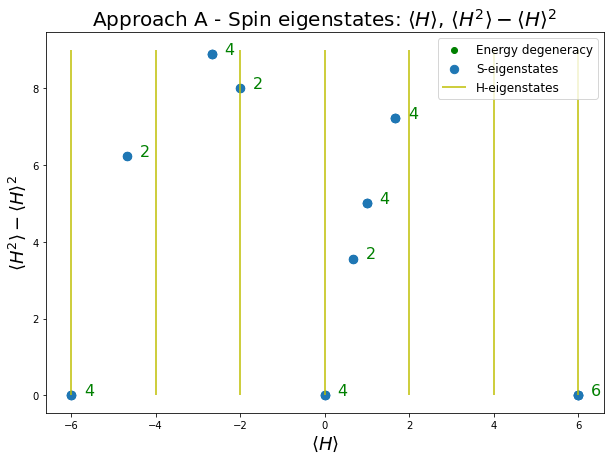

In [54]:
mean_H = [-6,-6,-6,-6,0,0,0,0,-2,-2,-4.667,-4.667,-2.667,-2.667,-2.667,-2.667,0.667,0.667,1.667,1.667,1.667,1.667,1,1,1,1,6,6,6,6,6,6]
var_H  = [1.56e-12,1.71e-13,5.90e-13,6.25e-13,1.41e-28,3.63e-16,3.63e-16,7.40e-32,8,8,6.22,6.22,8.89,8.89,8.89,8.89,3.56,3.56,7.22,7.22,7.22,7.22,5,5,5,5,1.02e-12,9.02e-13,5.83e-13,4.05e-13,2.56e-13,0]
x_mean = [-6,-4.667,-2.667,-2,0,0.667,1,1.667,6]
y_var = [0,6.22,8.89,8,0,3.56,5,7.22,0]
deg    = [4,2,4,2,4,2,4,4,6] 
plt.figure(figsize=(10,7))
plt.scatter(-6,0,color="g",label="Energy degeneracy")       # To give labels to degeneracies annotated
plt.scatter(mean_H,var_H,s=70,label="S-eigenstates")
for i,el in enumerate(deg):
    plt.annotate(el,(x_mean[i]+0.3,y_var[i]),color="g",size=16)
plt.vlines([-6,-4,-2,0,2,4,6],0,9,color="y",label="H-eigenstates")
plt.title(r"Approach A - Spin eigenstates: $\langle H \rangle$, $\langle H^2 \rangle - \langle H \rangle^2$",size=20)
plt.xlabel(r"$\langle H \rangle$",size=18)
plt.ylabel(r"$\langle H^2 \rangle - \langle H \rangle^2$",size=18)
plt.legend(fontsize=12)


### 3b - Ground states only

If we just want to build the circuits corresponding to our ground states, the procedure is easier because of the symmetry properties of the ground state. The ground state has the following possible configurations for $(s_l,s_m,s_r)$:

$$\biggl( 1,\frac{1}{2}, 0 \biggr) \quad \biggl( 0,\frac{1}{2}, 0 \biggr) \quad \biggl( 0,\frac{1}{2}, 1 \biggr)$$

Therefore the circuit can be built with the gates described above **without adding more controlled gates**.

We remind that the structure inside $U$ and $V$ is the following:
<img src="Pictures/CG1.jpg" width="400">

Circuit for ground state with configuration $\biggl( 1,\frac{1}{2}, 0 \biggr)$
<img src="Pictures/CG4.jpeg" width="600">

Circuit for ground state with configuration $\biggl( 0,\frac{1}{2}, 0 \biggr)$
<img src="Pictures/CG5.jpeg" width="600">

Circuit for ground state with configuration $\biggl( 0,\frac{1}{2}, 1 \biggr)$
<img src="Pictures/CG6.jpeg" width="600">

We remind that all the ground states have spin $j_{LC}=J=1/2$, so we will use as argument only $j_L$, $j_R$ and $M=\pm 1/2$.

In [15]:
def three_spin2(r,J,M):                                 # Three spin 1/2
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    theta=np.arccos(get_clebsch(r,M-0.5,0.5,0.5,J,M))  # Gives the angle to use in the Ry Gate
    #print("theta_LC = ",theta)
    
    qc.append(two_spin(r,M-0.5),[1,2])
    qc.ry(2*theta,0)                                   # Remember that we need to insert 2*theta
    qc.append(two_to_three(r,M).control(1),[0,1,2])    # Target [1,2], Control [0]
    #print(qc.draw())
    three_spin=qc.to_gate(label="RC-spin")
    return three_spin

qr = QuantumRegister(3,'q')                 
qc = QuantumCircuit(qr)
qc.append(three_spin2(0,0.5,0.5),[0,1,2])

# (l,r) \in {(0,0),(0,1),(1,0)}
# We remind that J_{LC}=J=0.5 in the ground states
def gs_spin(l,r,M):
    qr = QuantumRegister(nqubit,'q')                 
    qc = QuantumCircuit(qr)
    
    if r==0:
        qc.append(three_spin(l,0.5,M),[0,1,2])
        qc.append(two_spin(r,r),[3,4])
    else:
        qc.append(three_spin2(r,0.5,M),[2,3,4])
        qc.append(two_spin(l,l),[0,1])

    #print(qc.draw())
    gs_spin=qc.to_gate(label="GS-spin")
    return gs_spin

qr = QuantumRegister(nqubit,'q')                 
qc = QuantumCircuit(qr)
qc.append(gs_spin(0,0,0.5),[0,1,2,3,4])

#### Check - Ground state vectors

In [26]:
gs_list=[(0,0,-0.5),(0,0,0.5),(0,1,-0.5),(0,1,0.5),(1,0,-0.5),(1,0,0.5)]
v0=np.zeros(2**nqubit)
v0[0]=1
mat_H2=np.dot(mat_H,mat_H)

for i,el in enumerate(gs_list):
    print("| l=",el[0],",r=",el[1],"M=",el[2],"> = ", to_ket(np.real(np.dot(Operator(gs_spin(el[0],el[1],el[2])).data,v0))))
    s=to_state(np.real(np.dot(Operator(gs_spin(el[0],el[1],el[2])).data,v0)))
    #print("|",el,"> = ",s)
    E=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H,s)))
    E2=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H2,s)))
    #print("< ideal| ideal > = ",np.dot(np.conjugate(gs[i][1]),gs[i][1]))
    #print("< circuit| circuit > = ",np.dot(np.conjugate(s),s))
    print("< ideal| circuit > = ",np.dot(np.conjugate(gs[i][1]),s))
    print("<H> = ",E)
    print("<H^2> - <H>^2 = ",E2-E**2,"\n")
    

| l= 0 ,r= 0 M= -0.5 > =   + (0.500) |10110⟩ + (-0.500) |01110⟩ + (-0.500) |10101⟩ + (0.500) |01101⟩
< ideal| circuit > =  0.9999999999999998
<H> =  -5.999999999999996
<H^2> - <H>^2 =  2.842170943040401e-14 

| l= 0 ,r= 0 M= 0.5 > =   + (0.500) |10010⟩ + (-0.500) |01010⟩ + (-0.500) |10001⟩ + (0.500) |01001⟩
< ideal| circuit > =  0.9999999999999999
<H> =  -5.9999999999999964
<H^2> - <H>^2 =  1.4210854715202004e-14 

| l= 0 ,r= 1 M= -0.5 > =   + (-0.289) |10110⟩ + (0.289) |01110⟩ + (-0.289) |10101⟩ + (0.289) |01101⟩ + (0.577) |10011⟩ + (-0.577) |01011⟩
< ideal| circuit > =  -1.0
<H> =  -5.999999999999998
<H^2> - <H>^2 =  1.4210854715202004e-14 

| l= 0 ,r= 1 M= 0.5 > =   + (-0.577) |10100⟩ + (0.577) |01100⟩ + (0.289) |10010⟩ + (-0.289) |01010⟩ + (0.289) |10001⟩ + (-0.289) |01001⟩
< ideal| circuit > =  -1.0
<H> =  -5.999999999999999
<H^2> - <H>^2 =  7.105427357601002e-15 

| l= 1 ,r= 0 M= -0.5 > =   + (0.577) |11010⟩ + (-0.289) |10110⟩ + (-0.289) |01110⟩ + (-0.577) |11001⟩ + (0.289) |1010

#### Classification with spin left and right
| Label $(s_{L},s_{LC},s_{R},s,s_z)$| $\langle \hat{H} \rangle$ | $\langle \hat{H}^2 \rangle - \langle \hat{H} \rangle^2$  |
| :-: | :-: | :-: |
|<img width=150/>|<img width=100/>|<img width=100/>|
|$(0,1/2,0,1/2,-1/2)$|$-6.0$|$2.84 \cdot 10^{-14}$|
| $(0,1/2,0,1/2,1/2)$  | $-6.0$ | $1.42 \cdot 10^{-14}$ | 
| $(0,1/2,1,1/2,-1/2)$ | $-6.0$| $1.42 \cdot 10^{-14}$ | 
| $(0,1/2,1,1/2,1/2)$ | $-6.0$ | $7.11 \cdot 10^{-15}$ | 
|$(1,1/2,0,1/2,-1/2)$ | $-6.0$ | $7.11 \cdot 10^{-15}$ |
|$(1,1/2,0,1/2,1/2)$ | $-6.0$ | $7.11 \cdot 10^{-15}$ | 

#### Similar ideas from papers

Paper with reference to the "one by one" construction of the total spin states:

- K. Sugisaki, S. Yamamoto, S. Nakazawa, K. Toyota, K. Sato, D. Shiomi, T. Takui, Quantum chemistry on quantum computers: a polynomial-time quantum algorithm for constructing the wave functions of open-shell molecules

- K. Sugisaki, S. Yamamoto, S. Nakazawa, K. Toyota, K. Sato, D. Shiomi, T. Takui, Open shell electronic state calculations on quantum computers: A quantum circuit for the preparation of configuration state functions based on Serber construction

They create a circuit to build a quantum state for $N$ spins which is composed by **spin couples of singlet states**. Therefore they study the easiest way.

<img src="Pictures/Sugisaki_circuit.png" width="800">

The notation $|\psi (N,s,s_z) \rangle$ involves the number of qubits $N$, the spin of $N$ qubits $s$ and the $z$-component of spin $s_z$.

#### Other ideas with ancillary gates

- **Linear Combination Unitaries** to create a superposition of states?
- Jaynes-Cummings with the idea of Martinis?

## Mario's suggestion - Case of a $3$-spin system

Mario's idea is to create a shallow circuit by realizing the following structure.

<img src="Pictures/CG8.jpeg" width="500">
We remind that:

$$\begin{align}
& \text{Singlet} \quad \frac{|\uparrow \downarrow \rangle -|\downarrow \uparrow \rangle}{\sqrt{2}} \quad G=XH \quad G'=X \\
& \text{Triplet} \quad
\begin{cases}
&|\uparrow \uparrow \rangle \quad G=\mathbb{1} \quad G'=\mathbb{1} \\
&\frac{|\uparrow \downarrow \rangle +|\downarrow \uparrow \rangle}{\sqrt{2}}  \quad G=H \quad G'=X\\
&|\downarrow \downarrow \rangle \quad G=X \quad G'=\mathbb{1}
\end{cases}
\end{align}
$$


By using exactly this method with the third qubit initialized as $|0\rangle$ or $|1\rangle$, we can only get the following states:

$$
\begin{align}
& |s_L=0,s=1/2,s_z=1/2 \rangle = \frac{1}{\sqrt{2}} \biggl(| \uparrow_0 \downarrow_1 \rangle - | \downarrow_0 \uparrow_1 \rangle\biggr)|\uparrow_2 \rangle\\
& |s_L=0,s=1/2,s_z=-1/2 \rangle = \frac{1}{\sqrt{2}} \biggl(| \uparrow_0 \downarrow_1 \rangle - | \downarrow_0 \uparrow_1 \rangle\biggr)|\downarrow_2 \rangle\\
& |s_L=1,s=3/2,s_z = -3/2 \rangle = | \downarrow_0 \downarrow_1 \downarrow_2\rangle  \\
& |s_L=1,s=3/2,s_z = 3/2 \rangle = | \uparrow_0 \uparrow_1 \uparrow_2\rangle  
\end{align}
$$

They are all the cases in which we have only $\uparrow_2$ or $\downarrow_2$.

If we introduce an **RY** gate before the action of the green and orange controlled gates, namely if we create a superposition of $\uparrow_2$ and $\downarrow_2$, we get a different situation.

<img src="Pictures/CG9.jpeg" width="600">

The complete circuit can also be described as follow:

<img src="Pictures/CG10.jpeg" width="600">

Moreover, we can make an additional simplification. We can split the two controlled gates into $2$ single-qubit controlled gates. 

<img src="Pictures/CG13.png" width="600">

In [16]:
# q refers to the qubit in which inserting the gate
def single_qubit_gate(w,J,M):
    qr = QuantumRegister(1,'q')                 
    qc = QuantumCircuit(qr)
    if J==0:
        if w==True:
            qc.x(0)
            qc.h(0)
        else:
            qc.x(0)
    else:
        if M==0:
            if w==True:
                qc.h(0)
            else:
                qc.x(0)
        elif M==-1:
            if w==True:
                qc.x(0)
    #print(qc.draw())
    #one_spin=qc.to_instruction()          # Another possible way to deal with the construction of the gate
    one_gate=qc.to_gate(label="single-qubit-gate")
    return one_gate

# LEFT CASE
def three_spin_shallow(l,J,M):
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(l,M-0.5,0.5,0.5,J,M))  
    '''
    Alternative approach
    theta=np.arccos(np.sqrt((l+M+0.5)/(2*l+1)))
    if l==1 and J==0.5:
        theta+=np.pi/2
    '''
    #print("theta_LC = ",theta)
    
    qc.ry(2*theta,2)                                            # Remember that we need to insert 2*theta
    qc.append(single_qubit_gate(True,l,M+0.5).control(1),[2,0])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M+0.5).control(1),[2,1]) # CNOT Target [1], Control [2]    
    qc.x(2)
    qc.append(single_qubit_gate(True,l,M-0.5).control(1),[2,0])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M-0.5).control(1),[2,1]) # CNOT Target [1], Control [2]
    qc.x(2)
    qc.cx(0,1)
    #print(qc.draw())
    three_spin=qc.to_gate(label="3-spin")
    return three_spin

# RIGHT CASE
def three_spin_shallow2(r,J,M):
    qr = QuantumRegister(3,'q')                 
    qc = QuantumCircuit(qr)
    
    # theta gives the angle to use in the Ry Gate
    theta=np.arccos(get_clebsch(r,M-0.5,0.5,0.5,J,M))  
    '''
    Alternative approach
    theta=np.arccos(np.sqrt((r+M+0.5)/(2*r+1)))
    if r==1 and J==0.5:
        theta+=np.pi/2
    '''
    #print("theta_LC = ",theta)
    
    qc.ry(2*theta,0)                                            # Remember that we need to insert 2*theta
    qc.append(single_qubit_gate(True,l,M+0.5).control(1),[0,1])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M+0.5).control(1),[0,2]) # CNOT Target [1], Control [2]    
    qc.x(0)
    qc.append(single_qubit_gate(True,l,M-0.5).control(1),[0,1])  # CNOT Target [0], Control [2]
    qc.append(single_qubit_gate(False,l,M-0.5).control(1),[0,2]) # CNOT Target [1], Control [2]
    qc.x(0)
    qc.cx(1,2)
    #print(qc.draw())
    three_spin=qc.to_gate(label="3-spin")
    return three_spin

In [19]:
lab_list=[(0,0.5,-0.5),(0,0.5,0.5),(1,0.5,-0.5),(1,0.5,0.5),(1,1.5,-1.5),(1,1.5,-0.5),(1,1.5,0.5),(1,1.5,1.5)]
v0=np.zeros(2**3)
v0[0]=1

fid_3spins=[]

print("Total spin eigenfunctions of a 3-spin system")
for il,l in enumerate(lab_list):
    print("|",lab_list[il],"> = ", to_ket(np.real(np.dot(Operator(three_spin_shallow(l[0],l[1],l[2])).data,v0))))
    s=to_state(np.real(np.dot(Operator(three_spin_shallow(l[0],l[1],l[2])).data,v0)))
    int_prod=np.dot(np.conjugate(eig_3spins[il]),s)
    fid_3spins.append(np.conjugate(int_prod)*int_prod)
    print("|< ideal| circuit >|^2 = ",fid_3spins[il],"\n")
    #print("|",lab_list[il],"> = ",s)

Total spin eigenfunctions of a 3-spin system
| (0, 0.5, -0.5) > =   + (-0.707) |101⟩ + (0.707) |011⟩
|< ideal| circuit >|^2 =  1.0 

| (0, 0.5, 0.5) > =   + (-0.707) |100⟩ + (0.707) |010⟩
|< ideal| circuit >|^2 =  1.0 

| (1, 0.5, -0.5) > =   + (-0.816) |110⟩ + (0.408) |101⟩ + (0.408) |011⟩
|< ideal| circuit >|^2 =  1.0 

| (1, 0.5, 0.5) > =   + (-0.408) |100⟩ + (-0.408) |010⟩ + (0.816) |001⟩
|< ideal| circuit >|^2 =  0.9999999999999998 

| (1, 1.5, -1.5) > =   + (1.000) |111⟩
|< ideal| circuit >|^2 =  1.0 

| (1, 1.5, -0.5) > =   + (0.577) |110⟩ + (0.577) |101⟩ + (0.577) |011⟩
|< ideal| circuit >|^2 =  1.0 

| (1, 1.5, 0.5) > =   + (0.577) |100⟩ + (0.577) |010⟩ + (0.577) |001⟩
|< ideal| circuit >|^2 =  1.0 

| (1, 1.5, 1.5) > =  (1.000) |000⟩
|< ideal| circuit >|^2 =  1.0 



| Label $(s_{01},s,s_z)$| $|\langle \psi_{ideal}|\psi_{circuit} \rangle|^2$ | 
| :-: | :-: | 
|<img width=150/>|<img width=150/>|
|$(0,1/2,-1/2)$|$1.0$|
|$(0,1/2,1/2)$  | $1.0$ | 
|$(1,1/2,-1/2)$|$1.0$|
|$(1,1/2,1/2)$  | $1.0-2.2\cdot 10^{-16}$ | 
|$(1,3/2,-3/2)$ | $1.0$| 
|$(1,3/2,-1/2)$ | $1.0$ | 
|$(1,3/2,1/2)$ |$1.0$ | 
|$(1,3/2,3/2)$ | $1.0$ |  

<Figure size 432x288 with 0 Axes>

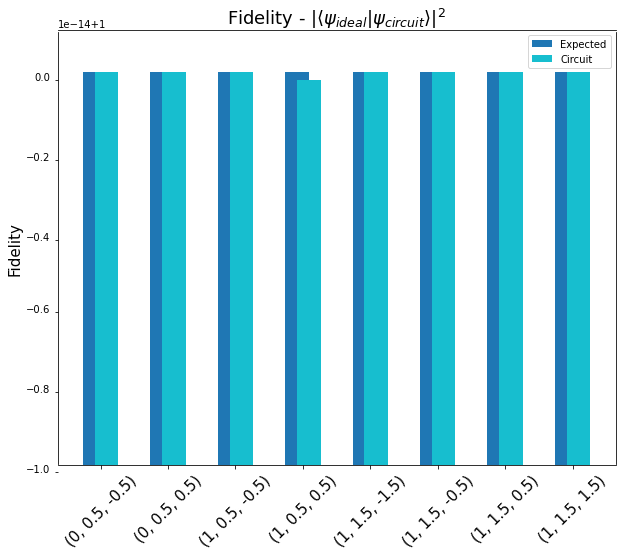

In [92]:
plt.figure()
exp_means=[1.0]*len(fid_3spins)
x_lab=np.arange(len(fid_3spins))
width=0.35


fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x_lab - width/4, exp_means, width, label='Expected',color='tab:blue')
rects2 = ax.bar(x_lab + width/4, fid_3spins, width, label='Circuit',color='tab:cyan')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fidelity',fontsize=15)
ax.set_title(r'Fidelity - $|\langle \psi_{ideal}|\psi_{circuit} \rangle |^2$',fontsize=18)
ax.set_xticks(x_lab)
ax.set_ylim(1-10e-15, 1+10e-16)
ax.set_xticklabels(lab_list,rotation=45,size=15)
ax.legend()


#### Case of $|s_L=1,s=1/2,s_z=1/2 \rangle$

<Figure size 432x288 with 0 Axes>

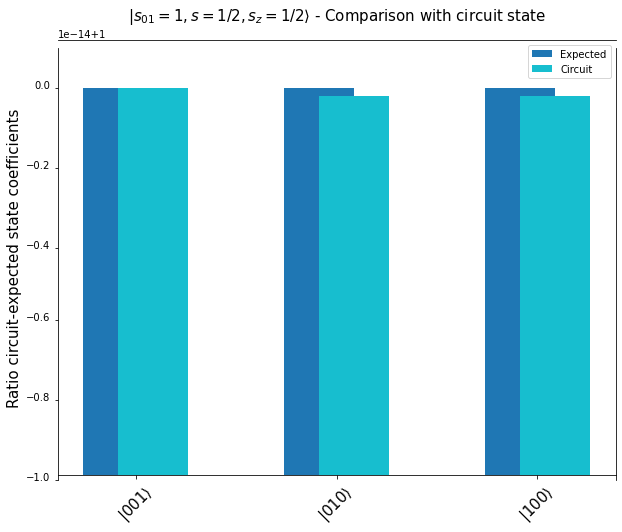

In [130]:
plt.figure()
exp_means=[]
for el in eig_3spins[3]:
    if np.round(el,5)!=0:
        exp_means.append(el)
x_lab=np.arange(len(exp_means))

circ_means=[]
circ_state=to_state(np.real(np.dot(Operator(three_spin_shallow(1,0.5,0.5)).data,v0)))
for el in circ_state:
    if np.round(el,5)!=0:
        circ_means.append(el)
width=0.35

comp_val=[]
for i in range(3):
    comp_val.append(circ_means[i]/exp_means[i])

exp_val=[1.0]*3

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x_lab - width/4, exp_val, width, label='Expected',color='tab:blue')
rects2 = ax.bar(x_lab + width/4, comp_val, width, label='Circuit',color='tab:cyan')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio circuit-expected state coefficients',fontsize=15)
ax.set_title(r'$| s_{01}=1,s=1/2,s_z=1/2 \rangle$ - Comparison with circuit state',fontsize=15,pad=20)
ax.set_xticks(x_lab)
ax.set_ylim(1-10e-15, 1+10e-16)
ax.set_xticklabels([r"$|001\rangle$",r"$|010\rangle$",r"$|100\rangle$"],rotation=45,size=15)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(np.round(height,15)*100),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects2)

### Creating a shallow circuit for $5$-spin eigenstates

We look again at the lowest energy eigenstates of the Hamiltonian on the bow-tie lattice.

$$
\begin{align}
& |\text{config}=( 1,1/2, 0),s=\frac{1}{2},s_z=\frac{1}{2} \rangle=\sqrt{\frac{1}{3}} \biggl[\uparrow_0 \uparrow_1 \downarrow_2 -  \frac{1}{2} \biggl( \uparrow_0 \downarrow_1 + \downarrow_0 \uparrow_1 \biggr) \uparrow_2 \biggr] \biggl(\uparrow_3\downarrow_4 -\downarrow_3 \uparrow_4 \biggr) \quad \text{+ (spin flip, sign change)}\\
& |\text{config}=( 0,1/2, 1),s=\frac{1}{2},s_z=\frac{1}{2} \rangle= \sqrt{\frac{1}{3}} \biggl(\uparrow_0 \downarrow_1 -\downarrow_0 \uparrow_1 \biggr) \biggl[\downarrow_2 \uparrow_3 \uparrow_4-  \frac{1}{2} \uparrow_2 \biggl( \uparrow_3 \downarrow_4 + \downarrow_3 \uparrow_4 \biggr)  \biggr] \quad \text{+ (spin flip, sign change)}  \\
& |\text{config}=( 0,1/2, 0),s=\frac{1}{2},s_z=\frac{1}{2} \rangle = \frac{1}{2} \biggl(\uparrow_0 \downarrow_1 -\downarrow_0 \uparrow_1 \biggr) \uparrow_2 \biggl(\uparrow_3 \downarrow_4 -\downarrow_3 \uparrow_4 \biggr) \quad \text{+ spin flip (same with}\downarrow_2\text{)}
\end{align}
$$

The idea of removing the **CNOT** gates which appear one next to the other in the registers above is not possibile because the **CNOT** inside $U^\dagger U'$ and $V^\dagger V'$ are in turn controlled by the qubit $2$. By trying to remove them we would not obtain ground states of the Heisenberg Hamiltonian.

By the way, we can make the circuit easier by removing the odd gates inside the singlet states and using the idea above for 3 spins to make the circuit more shallow.

In [44]:
def gs_spin_shallow(l,r,M):
    qr = QuantumRegister(nqubit,'q')                 
    qc = QuantumCircuit(qr)
    
    if l==0 and r==0:
        # Qubits 0-1
        qc.x(0)
        qc.h(0)
        qc.x(1)
        qc.cx(0,1)
        
        # Qubits 3-4
        qc.x(3)
        qc.h(3)
        qc.x(4)
        qc.cx(3,4)
        
        if M<0:
            qc.x(2)
            
    elif l==1 and r==0:
        qc.append(three_spin_shallow(l,0.5,M),[0,1,2])
        qc.append(two_spin(r,r),[3,4])
        
    else:
        qc.append(three_spin_shallow2(r,0.5,M),[2,3,4])
        qc.append(two_spin(l,l),[0,1])


    #print(qc.draw())
    gs_spin=qc.to_gate(label="GS-spin")
    return gs_spin

In [45]:
gs_list=[(0,0,-0.5),(0,0,0.5),(0,1,-0.5),(0,1,0.5),(1,0,-0.5),(1,0,0.5)]
v0=np.zeros(2**nqubit)
v0[0]=1
mat_H2=np.dot(mat_H,mat_H)

for i,el in enumerate(gs_list):
    print("|",el,"> = ", to_ket(np.real(np.dot(Operator(gs_spin_shallow(el[0],el[1],el[2])).data,v0))))
    s=to_state(np.real(np.dot(Operator(gs_spin_shallow(el[0],el[1],el[2])).data,v0)))
    #print("|",el,"> = ",s)
    E=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H,s)))
    E2=np.real(np.dot(np.conjugate(np.transpose(s)),np.dot(mat_H2,s)))
    print("< ideal| circuit > = ",np.dot(np.conjugate(gs[i][1]),s))
    print("<H> = ",E)
    print("<H^2> - <H>^2 = ",E2-E**2,"\n")

| (0, 0, -0.5) > =   + (0.500) |10110⟩ + (-0.500) |01110⟩ + (-0.500) |10101⟩ + (0.500) |01101⟩
< ideal| circuit > =  1.0
<H> =  -5.999999999999997
<H^2> - <H>^2 =  1.4210854715202004e-14 

| (0, 0, 0.5) > =   + (0.500) |10010⟩ + (-0.500) |01010⟩ + (-0.500) |10001⟩ + (0.500) |01001⟩
< ideal| circuit > =  1.0
<H> =  -5.999999999999997
<H^2> - <H>^2 =  1.4210854715202004e-14 

| (0, 1, -0.5) > =   + (-0.289) |10110⟩ + (0.289) |01110⟩ + (-0.289) |10101⟩ + (0.289) |01101⟩ + (0.577) |10011⟩ + (-0.577) |01011⟩
< ideal| circuit > =  -1.0
<H> =  -5.999999999999998
<H^2> - <H>^2 =  1.4210854715202004e-14 

| (0, 1, 0.5) > =   + (-0.577) |10100⟩ + (0.577) |01100⟩ + (0.289) |10010⟩ + (-0.289) |01010⟩ + (0.289) |10001⟩ + (-0.289) |01001⟩
< ideal| circuit > =  -1.0
<H> =  -5.999999999999999
<H^2> - <H>^2 =  7.105427357601002e-15 

| (1, 0, -0.5) > =   + (0.577) |11010⟩ + (-0.289) |10110⟩ + (-0.289) |01110⟩ + (-0.577) |11001⟩ + (0.289) |10101⟩ + (0.289) |01101⟩
< ideal| circuit > =  1.0
<H> =  -5.999

#### Classification with spin left and right
| Label $(s_{L},s_{LC},s_{R},s,s_z)$| $\langle \hat{H} \rangle$ | $\langle \hat{H}^2 \rangle - \langle \hat{H} \rangle^2$  |
| :-: | :-: | :-: |
|<img width=150/>|<img width=100/>|<img width=100/>|
|$(0,1/2,0,1/2,-1/2)$|$-6.0$|$1.42 \cdot 10^{-14}$|
| $(0,1/2,0,1/2,1/2)$  | $-6.0$ | $1.42 \cdot 10^{-14}$ | 
| $(0,1/2,1,1/2,-1/2)$ | $-6.0$| $1.42 \cdot 10^{-14}$ | 
| $(0,1/2,1,1/2,1/2)$ | $-6.0$ | $7.11 \cdot 10^{-15}$ | 
|$(1,1/2,0,1/2,-1/2)$ | $-6.0$ | $7.11 \cdot 10^{-15}$ |
|$(1,1/2,0,1/2,1/2)$ | $-6.0$ | $7.11 \cdot 10^{-15}$ | 

**Remarks/Questions**

- The precision on energy is the same for both the circuit and its shallow version above. 

**Other ways to compute the Clebsh-Gordan coefficients**

- Look at (1.20) of *Ruben Pauncz - Spin Eigenfunctions: Construction and Use*.

<img src="Pictures/Pauncz_CG.png" width="600">

- Look at *Bacon, Chuang, Harrow - Efficient Quantum Circuits for Schur and Clebsch-Gordan Transforms*. In the case of composition of a spins $J$ and $1/2$:

<img src="Pictures/BCH_CG.png" width="600">

where $J_\pm' = J +1/2$, $m_\pm=m' \pm 1/2$ and $\text{cos}\theta_{J,m'}=\sqrt{\frac{J + m' + 1/2}{2J+1}}$. 

## Analysis of scalability of CG circuits

We are going to study the **number of CNOT gates** and the **depth of the circuits** coming from the Clebsh-Gordan approach (One-to-one circuits).  

**$3$-spin case**
We consider the $3$-spin general circuit.

<img src="Pictures/CG13.png" width="600">

Now we focus on the state $(0,1/2,-1/2)$. This is the state with the biggest depth and the biggest number of CNOT gates.

<img src="Pictures/CG_3_lab0.png" width="600">

In the case above, using *Barenco et al. - Elementary gates for quantum computation*, we can divide the controlled-Hadamard, **CHGate**, into $1$ single qubit gate and $2$ CNOT gates. By this way we can evaluate the depth and the number of CNOTs. For a general circuit we have:

<img src="Pictures/CG17.png" width="800">
PLOT WRONG: 4 SINGLE QUBIT GATES MISSING IN THE FIRST WIRE

The depth and the number of CNOT gates of the circuit above are equal to $11$.


**$4$-spin case**
When we consider the $4$-spin case and the following ones we use the general scheme below:

<img src="Pictures/CG19.png" width="700">

If we focus only on circuit $W$ and look at $V$ and $V^\dagger V'$ on the first three qubits, which gates do we have to consider for our analysis?

First of all we can make the following assumption.

<img src="Pictures/CG20.png" width="800">

We want to give an estimate of the most entangled and deep circuits, therefore we notice that in the worst cases the circuits contain Pauli $X$-gates inside $G_0'$ and $G_1'$. This is a consequence of the gates used for building singlet and triplet states. Therefore the only difference between $V$ and $V'$ are the single qubit gates $H_0^{SQ}$ and $H_1^{SQ}$. We can keep the same gates of $V$, but we split $H_0^{SQ}$ and $H_1^{SQ}$ into two controlled single qubit gates (one controlled when $4$th qubit is $|0\rangle$, the other when it's $|1\rangle$). See below. 

<img src="Pictures/CG18.png" width="800">

From *Barenco* we know that the each of the $4$ controlled single qubit gates, $H_i^{V}$ and $H_i^{V^\dagger V'}$ with $i=0,1$, on the first qubit involves $2$ CNOTs, therefore we have introduced $8$ CNOTs ($4 \times 2$). Besides, we see that the first qubits is also the one which accounts for the depth of the circuit.

**Larger spin cases**
From this point forward we have that each single qubit gates appearing on the first qubit line will be always splitted into two controlled single qubit gates. Each controlled single qubit gate can be described (*Barenco*) as two CNOTs and one single qubit gate. In each step we see an increasing of almost $2$ in both depth and number of CNOTs because of that.
In particular the depth can be evaluated by noticing that the first line is always the line which involves more gates (or time steps). 

If we call $n$ the number of qubits, $N_{CSQ}(n)$ the number of controlled single qubit gates with $n$ qubits (CNOT excluded), we can summarize the behavior of number of CNOTs and the depth ,$N_{CNOT}$ and $d$, with an increasing number of spins/qubits $n$.

$$ N_{CNOT} = 
\begin{cases}
& 1 & n=2 \\
& 3^2 + 2^{n-1} &n>2
\end{cases}
\quad 
\quad
d = 
\begin{cases}
& 3 & n=2 \\
& 3^2 &n=3 \\
& 3^2 - 2^{n-3} + 3 \cdot2^{n-2} & n>3
\end{cases}
$$


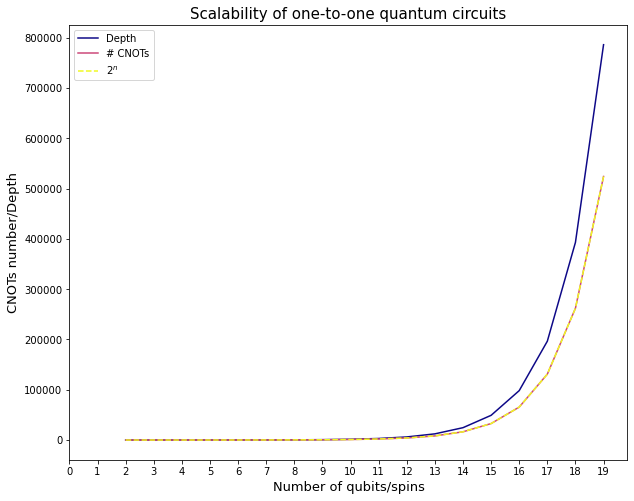

In [5]:
jet = plt.get_cmap('plasma')
colors = iter(jet(np.linspace(0,1,3)))

def circ_depth(n):
    if n==2:
        return 3
    elif n==3:
        return 9 
    else:
        return 7 - 2**(n-1) + (2*2**(n))
    
def n_CNOT(n):
    if n==2:
        return 1
    else:
        return 3**2 + 2**(n)

x = np.arange(2,20)
y1 = [circ_depth(x1) for x1 in x]
y2 = [n_CNOT(x2) for x2 in x]
plt.figure(figsize=(10,8))
plt.plot(x, y1, label="Depth", color=next(colors))
plt.plot(x, y2,label="# CNOTs",color=next(colors))
plt.plot(x,2**(x), "--",label=r"$2^{n}$",color=next(colors))

plt.title("Scalability of one-to-one quantum circuits",size=15)
plt.xlabel("Number of qubits/spins",size=13)
plt.ylabel("CNOTs number/Depth",size=13)
plt.xticks(np.arange(20))
plt.legend()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/CG_scalability.pdf")

In [13]:
qc = QuantumCircuit(2)
qc.ch(0,1)
print(qc.draw())
print(Operator(qc).data)

          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ H ├
     └───┘
[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j  0.70710678+0.j]
 [ 0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j -0.70710678+0.j]]


In [12]:
qc = QuantumCircuit(2)
qc.ry(np.pi/4,1)
qc.cx(0,1)
qc.ry(-np.pi/4,1)
print(qc.draw())
print(Operator(qc).data)

                                 
q_0: ─────────────■──────────────
     ┌─────────┐┌─┴─┐┌──────────┐
q_1: ┤ RY(π/4) ├┤ X ├┤ RY(-π/4) ├
     └─────────┘└───┘└──────────┘
[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j  0.70710678+0.j]
 [ 0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.        +0.j -0.70710678+0.j]]
